In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns
import statsmodels.api as sm
%matplotlib inline

from collections import namedtuple
from importlib import reload
from matplotlib import cm
from imblearn.under_sampling import TomekLinks, RandomUnderSampler
from imblearn.over_sampling import SMOTE

from sklearn.model_selection import train_test_split
from sklearn.metrics import (make_scorer, roc_auc_score, 
                             classification_report, 
                             precision_recall_curve,
                             roc_curve)
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KernelDensity
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import AgglomerativeClustering
#from xgboost import XGBClassifier

from feature_processing import (create_contingency_table,
                                calculate_conditional_prob_bin,
                                encode_my_categorical_labels,
                                calculate_conditional_prob_cat,
                                estimate_cond_prob_density,
                                bin_myFeature)
import feature_analysis as fa
import porto_seguro as ps

import warnings
warnings.simplefilter("ignore", category=PendingDeprecationWarning)
warnings.simplefilter("ignore", category=DeprecationWarning)

/home/ryohayama/.local/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
def my_gini(y_true, y_probas):
    auc = roc_auc_score(y_true, y_probas[:, 1])
    gini = 2*auc - 1
    return gini

gini_scorer = make_scorer(my_gini, needs_proba=True, greater_is_better=True)

In [3]:
train = pd.read_csv('train.csv', header=0)

all_fs = train.columns[2:]
binary_fs = sorted([f for f in all_fs if '_bin' in f])
categorical_fs = sorted([f for f in all_fs if '_cat' in f])
other_fs = sorted([f for f in all_fs
                if f not in binary_fs
                if f not in categorical_fs])

binaries = train[binary_fs]
categoricals = ps.fuseCategoricalFeatures(train[categorical_fs])
cont_ordinals = train[other_fs]
target = train.target

train.shape, binaries.shape, categoricals.shape, cont_ordinals.shape

((595212, 59), (595212, 17), (595212, 14), (595212, 26))

In [4]:
train.columns

Index(['id', 'target', 'ps_ind_01', 'ps_ind_02_cat', 'ps_ind_03',
       'ps_ind_04_cat', 'ps_ind_05_cat', 'ps_ind_06_bin', 'ps_ind_07_bin',
       'ps_ind_08_bin', 'ps_ind_09_bin', 'ps_ind_10_bin', 'ps_ind_11_bin',
       'ps_ind_12_bin', 'ps_ind_13_bin', 'ps_ind_14', 'ps_ind_15',
       'ps_ind_16_bin', 'ps_ind_17_bin', 'ps_ind_18_bin', 'ps_reg_01',
       'ps_reg_02', 'ps_reg_03', 'ps_car_01_cat', 'ps_car_02_cat',
       'ps_car_03_cat', 'ps_car_04_cat', 'ps_car_05_cat', 'ps_car_06_cat',
       'ps_car_07_cat', 'ps_car_08_cat', 'ps_car_09_cat', 'ps_car_10_cat',
       'ps_car_11_cat', 'ps_car_11', 'ps_car_12', 'ps_car_13', 'ps_car_14',
       'ps_car_15', 'ps_calc_01', 'ps_calc_02', 'ps_calc_03', 'ps_calc_04',
       'ps_calc_05', 'ps_calc_06', 'ps_calc_07', 'ps_calc_08', 'ps_calc_09',
       'ps_calc_10', 'ps_calc_11', 'ps_calc_12', 'ps_calc_13', 'ps_calc_14',
       'ps_calc_15_bin', 'ps_calc_16_bin', 'ps_calc_17_bin', 'ps_calc_18_bin',
       'ps_calc_19_bin', 'ps_calc_20_bin'],


In [5]:
binary_fs

['ps_calc_15_bin',
 'ps_calc_16_bin',
 'ps_calc_17_bin',
 'ps_calc_18_bin',
 'ps_calc_19_bin',
 'ps_calc_20_bin',
 'ps_ind_06_bin',
 'ps_ind_07_bin',
 'ps_ind_08_bin',
 'ps_ind_09_bin',
 'ps_ind_10_bin',
 'ps_ind_11_bin',
 'ps_ind_12_bin',
 'ps_ind_13_bin',
 'ps_ind_16_bin',
 'ps_ind_17_bin',
 'ps_ind_18_bin']

In [6]:
num_samples = len(target)
num_target = np.sum(target)
freq_target = num_target/num_samples
freq_target

0.036447517859182946

# Binaries

### Ind features

In [7]:
ind_bins_fs = [f for f in all_fs 
               if '_bin' in f
               if '_ind' in f]

In [8]:
ind_bins = train[ind_bins_fs]
ind_bins_fs

['ps_ind_06_bin',
 'ps_ind_07_bin',
 'ps_ind_08_bin',
 'ps_ind_09_bin',
 'ps_ind_10_bin',
 'ps_ind_11_bin',
 'ps_ind_12_bin',
 'ps_ind_13_bin',
 'ps_ind_16_bin',
 'ps_ind_17_bin',
 'ps_ind_18_bin']

In [9]:
for i, f in enumerate(ind_bins_fs):
    if -1 in ind_bins[f].unique():
        print('%s contains missing values' % f)
    else:
        print('%s doesn\'t contain missing values' % f)

ps_ind_06_bin doesn't contain missing values
ps_ind_07_bin doesn't contain missing values
ps_ind_08_bin doesn't contain missing values
ps_ind_09_bin doesn't contain missing values
ps_ind_10_bin doesn't contain missing values
ps_ind_11_bin doesn't contain missing values
ps_ind_12_bin doesn't contain missing values
ps_ind_13_bin doesn't contain missing values
ps_ind_16_bin doesn't contain missing values
ps_ind_17_bin doesn't contain missing values
ps_ind_18_bin doesn't contain missing values


In [10]:
%%time
ind_bins_joint = ind_bins.apply(tuple, axis=1)

CPU times: user 7.84 s, sys: 41.7 ms, total: 7.88 s
Wall time: 7.9 s


In [11]:
type(ind_bins_joint.iloc[0])

tuple

In [12]:
joint_contingency = pd.crosstab(ind_bins_joint, target)
joint_contingency['total'] = joint_contingency[0] + joint_contingency[1]
joint_contingency['frac_class1'] = joint_contingency[1]/joint_contingency['total']
#joint_contingency

In [13]:
joint_contingency.describe(percentiles=[0.25, 0.5, 0.75, 0.9, 0.95, 0.99])

target              0            1          total  frac_class1
count      161.000000   161.000000     161.000000   161.000000
mean      3562.223602   134.745342    3696.968944     0.044327
std      16336.760837   552.294614   16872.376686     0.128395
min          0.000000     0.000000       1.000000     0.000000
25%          2.000000     0.000000       2.000000     0.000000
50%          6.000000     0.000000       6.000000     0.000000
75%         43.000000     2.000000      44.000000     0.043117
90%       1022.000000    65.000000    1087.000000     0.091667
95%      15493.000000   868.000000   15897.000000     0.142857
99%      80026.000000  2981.600000   83007.600000     0.700000
max     154250.000000  4178.000000  158428.000000     1.000000

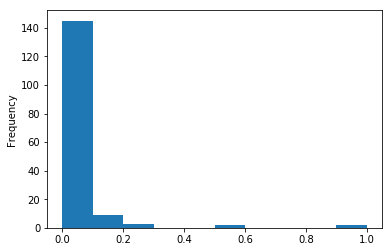

In [14]:
joint_contingency['frac_class1'].plot(kind='hist')

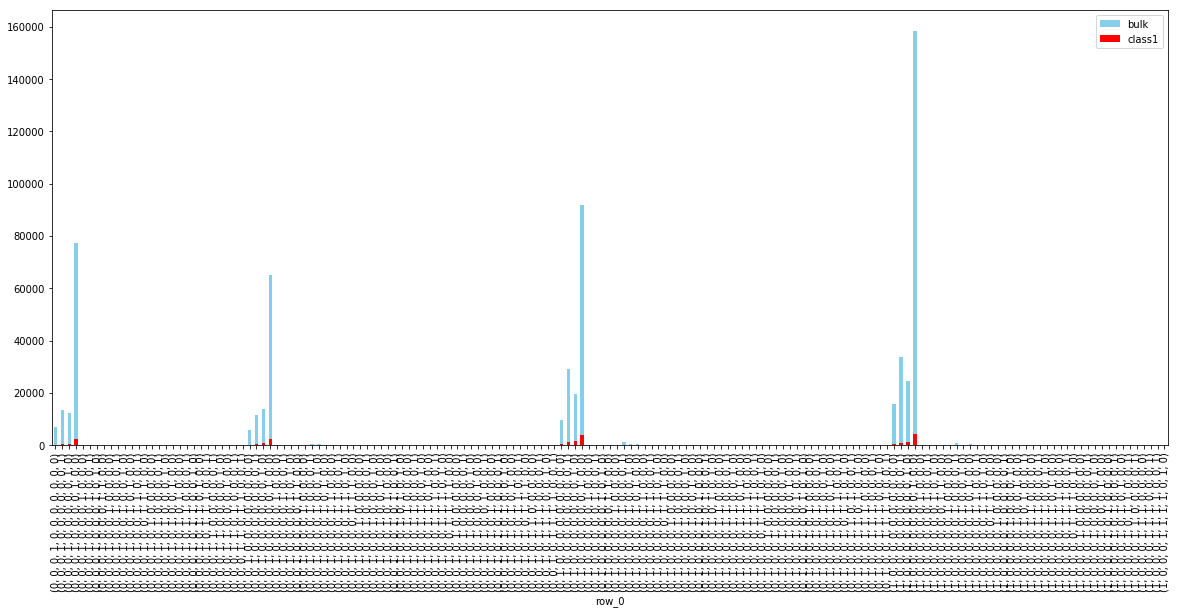

In [15]:
fig, ax = plt.subplots(1, 1, figsize=(20, 8))
joint_contingency.total.plot(kind='bar', ax=ax, color='skyblue', label='bulk')
joint_contingency[1].plot(kind='bar', ax=ax, color='red', label='class1')
ax.legend()

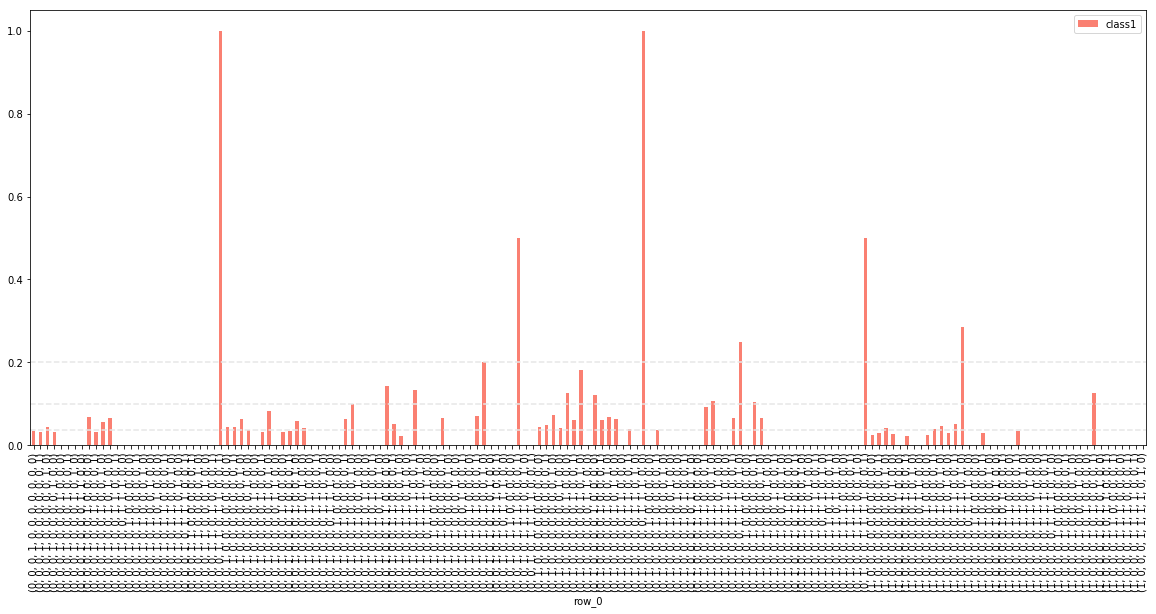

In [16]:
fig, ax = plt.subplots(1, 1, figsize=(20, 8))
#joint_contingency.total.plot(kind='bar', ax=ax, color='skyblue', label='bulk')
ax.axhline(y=freq_target, color='0.9', ls='--')
ax.axhline(y=0.1, color='0.9', ls='--')
ax.axhline(y=0.2, color='0.9', ls='--')
joint_contingency['frac_class1'].plot(kind='bar', ax=ax, color='salmon', label='class1')
ax.legend()

In [17]:
joint_contingency.sort_values('frac_class1', ascending=False)

target                                 0     1  total  frac_class1
row_0                                                             
(0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1)      0     1      1     1.000000
(0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0)      0     1      1     1.000000
(0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1)      1     1      2     0.500000
(0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1)      1     1      2     0.500000
(1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0)      5     2      7     0.285714
(0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0)      3     1      4     0.250000
(0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0)      8     2     10     0.200000
(0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0)     18     4     22     0.181818
(0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0)      6     1      7     0.142857
(0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1)     26     4     30     0.133333
(0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0)      7     1      8     0.125000
(1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1)      7     1      8     0.125000
(0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0)    101    14    115     0.121739
(0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0)     25     3     28     0.107143
(0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1)     26     3     29     0.103448
(0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0)     18     2     20     0.100000
(0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1)    109    11    120     0.091667
(0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0)     11     1     12     0.083333
(0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0)  18304  1437  19741     0.072793
(0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1)     13     1     14     0.071429
(0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0)     27     2     29     0.068966
(0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0)    402    29    431     0.067285
(0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0)     14     1     15     0.066667
(0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1)     14     1     15     0.066667
(0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1)     29     2     31     0.064516
(0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0)     87     6     93     0.064516
(0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1)     44     3     47     0.063830
(0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0)    389    26    415     0.062651
(0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0)  13142   868  14010     0.061956
(0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1)     78     5     83     0.060241
...                                  ...   ...    ...          ...
(0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0)      5     0      5     0.000000
(0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0)      1     0      1     0.000000
(0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0)      1     0      1     0.000000
(0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1)      7     0      7     0.000000
(0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0)      3     0      3     0.000000
(0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0)     12     0     12     0.000000
(0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0)      1     0      1     0.000000
(0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1)      7     0      7     0.000000
(0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0)      1     0      1     0.000000
(0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0)      9     0      9     0.000000
(0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0)     22     0     22     0.000000
(0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0)      4     0      4     0.000000
(0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0)     11     0     11     0.000000
(0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0)      3     0      3     0.000000
(0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1)      1     0      1     0.000000
(0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0)      1     0      1     0.000000
(0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0)      2     0      2     0.000000
(0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0)      1     0      1     0.000000
(0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1)      5     0      5     0.000000
(0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0)      2     0      2     0.000000
(0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0)      1     0      1     0.000000
(0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1)      2     0      2     0.000000
(0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0)      3     0      3     0.000000
(0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0)      3     0      3     0.000000
(0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0)      2     0      2     0.000000
(0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0)      1     0      1     0.000000
(0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0)      5     0 

In [18]:
joint_contingency.sort_values('frac_class1', ascending=True)

target                                 0     1  total  frac_class1
row_0                                                             
(0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0)      1     0      1     0.000000
(0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0)      1     0      1     0.000000
(0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0)      6     0      6     0.000000
(0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1)     24     0     24     0.000000
(0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0)      1     0      1     0.000000
(0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0)      3     0      3     0.000000
(0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1)      3     0      3     0.000000
(0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0)      5     0      5     0.000000
(0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0)      2     0      2     0.000000
(0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0)      1     0      1     0.000000
(0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0)      3     0      3     0.000000
(0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0)     12     0     12     0.000000
(0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0)      1     0      1     0.000000
(0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1)      7     0      7     0.000000
(0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0)      1     0      1     0.000000
(0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0)      9     0      9     0.000000
(0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0)     22     0     22     0.000000
(0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0)      4     0      4     0.000000
(0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0)     11     0     11     0.000000
(0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0)      3     0      3     0.000000
(1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1)      1     0      1     0.000000
(0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1)      1     0      1     0.000000
(0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0)      1     0      1     0.000000
(0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0)      2     0      2     0.000000
(0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0)      1     0      1     0.000000
(0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1)      5     0      5     0.000000
(0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0)      2     0      2     0.000000
(0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0)      1     0      1     0.000000
(0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1)      4     0      4     0.000000
(0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1)      2     0      2     0.000000
...                                  ...   ...    ...          ...
(0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1)     78     5     83     0.060241
(0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0)  13142   868  14010     0.061956
(0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0)    389    26    415     0.062651
(0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1)     44     3     47     0.063830
(0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0)     87     6     93     0.064516
(0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1)     29     2     31     0.064516
(0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0)     14     1     15     0.066667
(0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1)     14     1     15     0.066667
(0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0)    402    29    431     0.067285
(0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0)     27     2     29     0.068966
(0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1)     13     1     14     0.071429
(0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0)  18304  1437  19741     0.072793
(0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0)     11     1     12     0.083333
(0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1)    109    11    120     0.091667
(0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0)     18     2     20     0.100000
(0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1)     26     3     29     0.103448
(0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0)     25     3     28     0.107143
(0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0)    101    14    115     0.121739
(0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0)      7     1      8     0.125000
(1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1)      7     1      8     0.125000
(0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1)     26     4     30     0.133333
(0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0)      6     1      7     0.142857
(0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0)     18     4     22     0.181818
(0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0)      8     2     10     0.200000
(0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0)      3     1      4     0.250000
(1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0)      5     2      7     0.285714
(0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1)      1     1 

In [19]:
ind_bin_score = joint_contingency['frac_class1'].reset_index()
#ind_bin_score = (joint_contingency['frac_class1'] / np.max(joint_contingency['frac_class1'])).reset_index()

In [20]:
ind_bin_converted = pd.DataFrame()
ind_bin_converted['id'] = train['id']
ind_bin_converted['ind_bins_joint'] = ind_bins_joint

In [21]:
ind_bin_converted = pd.merge(ind_bin_converted, ind_bin_score, 
                     left_on='ind_bins_joint', right_on='row_0', copy=False).sort_values('id', ascending=True).reset_index(drop=True)

In [22]:
ind_bin_converted

id                     ind_bins_joint  \
0             7  (0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0)   
1             9  (0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1)   
2            13  (0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0)   
3            16  (1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0)   
4            17  (1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0)   
5            19  (0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0)   
6            20  (0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0)   
7            22  (1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0)   
8            26  (0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0)   
9            28  (0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1)   
10           34  (0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0)   
11           35  (0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0)   
12           36  (0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0)   
13           43  (0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0)   
14           46  (0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1)   
15           48  (0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1)   
16           50  (0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0)   
17           58  (1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0)   
18           61  (1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0)   
19           64  (1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0)   
20           65  (1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1)   
21           66  (1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0)   
22           72  (0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0)   
23           74  (0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0)   
24           77  (1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1)   
25           78  (1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0)   
26           79  (0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0)   
27           80  (0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0)   
28           84  (1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0)   
29           85  (1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0)   
...         ...                                ...   
595182  1487945  (1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0)   
595183  1487951  (1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0)   
595184  1487952  (1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1)   
595185  1487954  (0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0)   
595186  1487957  (0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0)   
595187  1487958  (0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0)   
595188  1487962  (1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0)   
595189  1487963  (1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)   
595190  1487964  (1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0)   
595191  1487968  (0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0)   
595192  1487973  (0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0)   
595193  1487975  (0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0)   
595194  1487976  (0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0)   
595195  1487980  (0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1)   
595196  1487983  (1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1)   
595197  1487988  (0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0)   
595198  1487990  (0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0)   
595199  1487992  (0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0)   
595200  1487994  (1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0)   
595201  1487996  (0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0)   
595202  1488001  (0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0)   
595203  1488005  (0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0)   
595204  1488008  (0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0)   
595205  1488009  (0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0)   
595206  1488011  (0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0)   
595207  1488013  (0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0)   
595208  1488016  (0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0)   
595209  1488017  (1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0)   
595210  1488021  (0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0)   
595211  1488027  (1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0)   

                                    row_0  frac_class1  
0       (0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0)     0.072793  
1       (0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1)     0.044951  
2       (0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0)     0.036999  
3       (1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0)     0.026372  
4       (1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0)     0.026372  
5       (0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0)     0.031435  
6       (0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0)     0.041577  
7       (1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0)     0.026372  
8       (0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0)     0.036999  
9       (0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1)     0.047745  
10      (0, 0, 1, 0, 0, 0, 0, 0, 1, 0

### calc features

In [23]:
calc_bins_fs = [f for f in binary_fs 
               if '_bin' in f
               if '_calc' in f]

In [24]:
calc_bins = train[calc_bins_fs]
calc_bins_fs

['ps_calc_15_bin',
 'ps_calc_16_bin',
 'ps_calc_17_bin',
 'ps_calc_18_bin',
 'ps_calc_19_bin',
 'ps_calc_20_bin']

In [25]:
for i, f in enumerate(calc_bins_fs):
    if -1 in calc_bins[f].unique():
        print('%s contains missing values' % f)
    else:
        print('%s doesn\'t contain missing values' % f)

ps_calc_15_bin doesn't contain missing values
ps_calc_16_bin doesn't contain missing values
ps_calc_17_bin doesn't contain missing values
ps_calc_18_bin doesn't contain missing values
ps_calc_19_bin doesn't contain missing values
ps_calc_20_bin doesn't contain missing values


In [26]:
%%time
calc_bins_joint = calc_bins.apply(tuple, axis=1)

CPU times: user 7.59 s, sys: 25.1 ms, total: 7.61 s
Wall time: 7.62 s


In [27]:
joint_contingency2 = pd.crosstab(calc_bins_joint, target)
joint_contingency2['total'] = joint_contingency2[0] + joint_contingency2[1]
joint_contingency2['allele_freq'] = joint_contingency2['total'] / num_samples
joint_contingency2['frac_class1'] = joint_contingency2[1]/joint_contingency2['total']
#joint_contingency2

In [28]:
joint_contingency2.describe(percentiles=[0.25, 0.5, 0.75, 0.9, 0.95, 0.99])

target             0           1         total  allele_freq  frac_class1
count      64.000000    64.00000     64.000000    64.000000    64.000000
mean     8961.218750   338.96875   9300.187500     0.015625     0.036289
std     13485.194133   514.15040  13999.020292     0.023519     0.007600
min       193.000000     5.00000    210.000000     0.000353     0.015660
25%      1290.000000    52.50000   1342.500000     0.002255     0.033824
50%      3484.500000   135.50000   3619.000000     0.006080     0.036371
75%      9694.750000   362.75000  10057.500000     0.016897     0.038415
90%     26161.400000  1011.90000  27173.300000     0.045653     0.040860
95%     36326.100000  1360.90000  37687.000000     0.063317     0.042013
99%     60168.320000  2324.26000  62492.580000     0.104992     0.058042
max     68696.000000  2575.00000  71271.000000     0.119741     0.080952

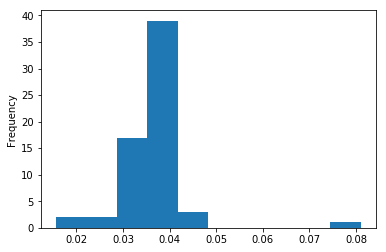

In [29]:
joint_contingency2['frac_class1'].plot(kind='hist')

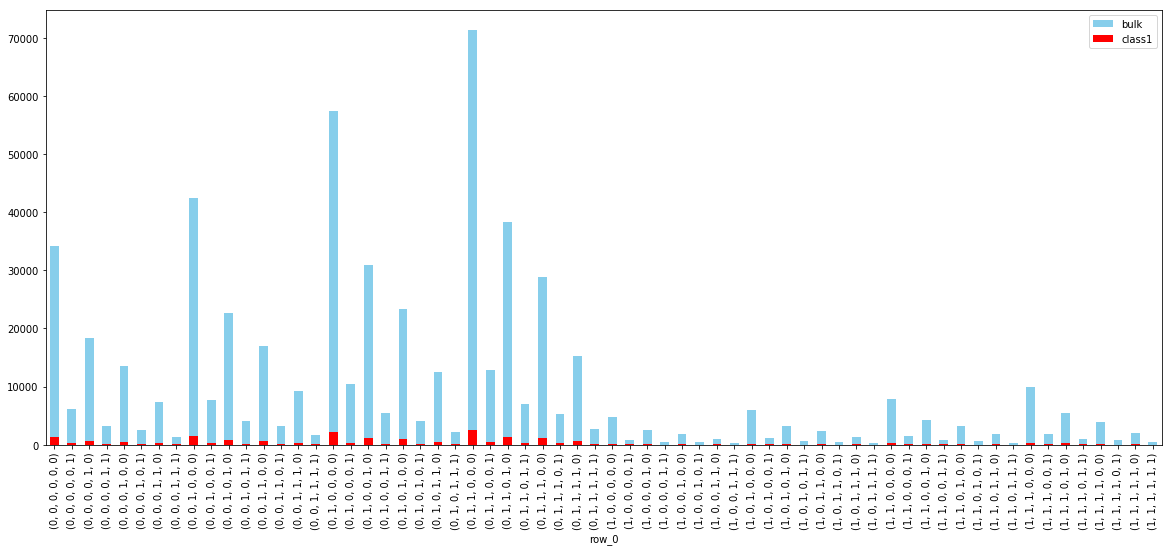

In [30]:
fig, ax = plt.subplots(1, 1, figsize=(20, 8))
joint_contingency2.total.plot(kind='bar', ax=ax, color='skyblue', label='bulk')
joint_contingency2[1].plot(kind='bar', ax=ax, color='red', label='class1')
ax.legend()

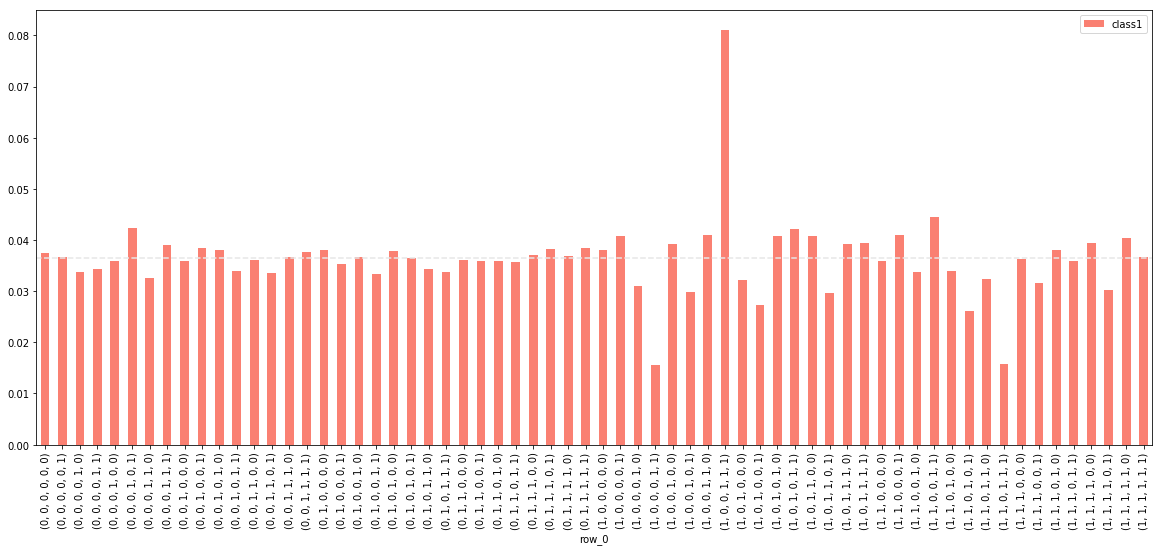

In [31]:
fig, ax = plt.subplots(1, 1, figsize=(20, 8))
#joint_contingency.total.plot(kind='bar', ax=ax, color='skyblue', label='bulk')
ax.axhline(y=freq_target, color='0.9', ls='--')
joint_contingency2['frac_class1'].plot(kind='bar', ax=ax, color='salmon', label='class1')
ax.legend()

In [32]:
joint_contingency2.sort_values('frac_class1', ascending=False)

target                  0     1  total  allele_freq  frac_class1
row_0                                                           
(1, 0, 0, 1, 1, 1)    193    17    210     0.000353     0.080952
(1, 1, 0, 0, 1, 1)    750    35    785     0.001319     0.044586
(0, 0, 0, 1, 0, 1)   2400   106   2506     0.004210     0.042298
(1, 0, 1, 0, 1, 1)    545    24    569     0.000956     0.042179
(1, 0, 0, 1, 1, 0)    934    40    974     0.001636     0.041068
(1, 1, 0, 0, 0, 1)   1475    63   1538     0.002584     0.040962
(1, 0, 1, 0, 1, 0)   3051   130   3181     0.005344     0.040868
(1, 0, 1, 1, 0, 0)   2278    97   2375     0.003990     0.040842
(1, 0, 0, 0, 0, 1)    800    34    834     0.001401     0.040767
(1, 1, 1, 1, 1, 0)   1993    84   2077     0.003490     0.040443
(1, 1, 1, 1, 0, 0)   3821   157   3978     0.006683     0.039467
(1, 0, 1, 1, 1, 1)    244    10    254     0.000427     0.039370
(1, 0, 0, 1, 0, 0)   1813    74   1887     0.003170     0.039216
(1, 0, 1, 1, 1, 0)   1251    51   1302     0.002187     0.039171
(0, 0, 0, 1, 1, 1)   1303    53   1356     0.002278     0.039086
(0, 1, 1, 1, 1, 1)   2645   106   2751     0.004622     0.038531
(0, 0, 1, 0, 0, 1)   7317   292   7609     0.012784     0.038376
(0, 1, 1, 1, 0, 1)   5014   199   5213     0.008758     0.038174
(1, 0, 0, 0, 0, 0)   4550   180   4730     0.007947     0.038055
(0, 0, 1, 0, 1, 0)  21739   860  22599     0.037968     0.038055
(1, 1, 1, 0, 1, 0)   5194   205   5399     0.009071     0.037970
(0, 1, 0, 0, 0, 0)  55160  2177  57337     0.096330     0.037969
(0, 1, 0, 1, 0, 0)  22527   888  23415     0.039339     0.037924
(0, 0, 1, 1, 1, 1)   1637    64   1701     0.002858     0.037625
(0, 0, 0, 0, 0, 0)  32887  1281  34168     0.057405     0.037491
(0, 1, 1, 1, 0, 0)  27719  1065  28784     0.048359     0.037000
(0, 1, 1, 1, 1, 0)  14741   565  15306     0.025715     0.036914
(0, 1, 0, 0, 1, 0)  29755  1135  30890     0.051897     0.036743
(0, 0, 0, 0, 0, 1)   5890   224   6114     0.010272     0.036637
(0, 0, 1, 1, 1, 0)   8897   338   9235     0.015515     0.036600
...                   ...   ...    ...          ...          ...
(0, 0, 1, 1, 0, 0)  16361   612  16973     0.028516     0.036057
(0, 0, 0, 1, 0, 0)  13101   488  13589     0.022831     0.035911
(0, 1, 1, 0, 1, 0)  36933  1375  38308     0.064360     0.035893
(1, 1, 1, 0, 1, 1)    994    37   1031     0.001732     0.035887
(0, 1, 1, 0, 0, 1)  12444   463  12907     0.021685     0.035872
(0, 0, 1, 0, 0, 0)  40998  1523  42521     0.071438     0.035818
(1, 1, 0, 0, 0, 0)   7646   284   7930     0.013323     0.035813
(0, 1, 1, 0, 1, 1)   6678   247   6925     0.011635     0.035668
(0, 1, 0, 0, 0, 1)  10060   368  10428     0.017520     0.035290
(0, 0, 0, 0, 1, 1)   3148   112   3260     0.005477     0.034356
(0, 1, 0, 1, 1, 0)  12103   430  12533     0.021056     0.034309
(0, 0, 1, 0, 1, 1)   4002   141   4143     0.006961     0.034033
(1, 1, 0, 1, 0, 0)   3127   110   3237     0.005438     0.033982
(1, 1, 0, 0, 1, 0)   4113   144   4257     0.007152     0.033827
(0, 0, 0, 0, 1, 0)  17657   618  18275     0.030703     0.033817
(0, 1, 0, 1, 1, 1)   2116    74   2190     0.003679     0.033790
(0, 0, 1, 1, 0, 1)   3022   105   3127     0.005254     0.033579
(0, 1, 0, 0, 1, 1)   5321   184   5505     0.009249     0.033424
(0, 0, 0, 1, 1, 0)   7018   237   7255     0.012189     0.032667
(1, 1, 0, 1, 1, 0)   1699    57   1756     0.002950     0.032460
(1, 0, 1, 0, 0, 0)   5746   191   5937     0.009975     0.032171
(1, 1, 1, 0, 0, 1)   1780    58   1838     0.003088     0.031556
(1, 0, 0, 0, 1, 0)   2463    79   2542     0.004271     0.031078
(1, 1, 1, 1, 0, 1)    704    22    726     0.001220     0.030303
(1, 0, 0, 1, 0, 1)    358    11    369     0.000620     0.029810
(1, 0, 1, 1, 0, 1)    394    12    406     0.000682     0.029557
(1, 0, 1, 0, 0, 1)   1037    29   1066     0.001791     0.027205
(1, 1, 0, 1, 0, 1)    559    15    574     0.000964     0.026132
(1, 1, 0, 1, 1, 1)    312     5    

In [33]:
calc_bin_score = joint_contingency2['frac_class1'].reset_index()
#calc_bin_score = (joint_contingency2['frac_class1'] / np.max(joint_contingency2['frac_class1'])).reset_index()

In [34]:
calc_bin_converted = pd.DataFrame()
calc_bin_converted['id'] = train['id']
calc_bin_converted['calc_bin_joint'] = calc_bins_joint

In [35]:
calc_bin_converted = pd.merge(calc_bin_converted, calc_bin_score, 
                     left_on='calc_bin_joint', right_on='row_0', copy=False).sort_values('id', ascending=True).reset_index(drop=True)

In [36]:
calc_bin_converted

id      calc_bin_joint               row_0  frac_class1
0             7  (0, 1, 1, 0, 0, 1)  (0, 1, 1, 0, 0, 1)     0.035872
1             9  (0, 1, 1, 0, 1, 0)  (0, 1, 1, 0, 1, 0)     0.035893
2            13  (0, 1, 1, 0, 1, 0)  (0, 1, 1, 0, 1, 0)     0.035893
3            16  (0, 0, 0, 0, 0, 0)  (0, 0, 0, 0, 0, 0)     0.037491
4            17  (0, 0, 0, 1, 1, 0)  (0, 0, 0, 1, 1, 0)     0.032667
5            19  (0, 1, 0, 1, 1, 1)  (0, 1, 0, 1, 1, 1)     0.033790
6            20  (0, 1, 0, 0, 1, 0)  (0, 1, 0, 0, 1, 0)     0.036743
7            22  (1, 0, 1, 0, 1, 0)  (1, 0, 1, 0, 1, 0)     0.040868
8            26  (0, 1, 0, 0, 0, 1)  (0, 1, 0, 0, 0, 1)     0.035290
9            28  (0, 1, 0, 0, 1, 0)  (0, 1, 0, 0, 1, 0)     0.036743
10           34  (0, 1, 1, 0, 1, 1)  (0, 1, 1, 0, 1, 1)     0.035668
11           35  (0, 1, 0, 1, 0, 0)  (0, 1, 0, 1, 0, 0)     0.037924
12           36  (0, 0, 1, 0, 0, 1)  (0, 0, 1, 0, 0, 1)     0.038376
13           43  (0, 0, 1, 0, 1, 0)  (0, 0, 1, 0, 1, 0)     0.038055
14           46  (0, 0, 0, 0, 1, 0)  (0, 0, 0, 0, 1, 0)     0.033817
15           48  (0, 1, 1, 0, 1, 0)  (0, 1, 1, 0, 1, 0)     0.035893
16           50  (0, 0, 1, 0, 0, 0)  (0, 0, 1, 0, 0, 0)     0.035818
17           58  (0, 1, 1, 0, 0, 0)  (0, 1, 1, 0, 0, 0)     0.036130
18           61  (0, 0, 0, 1, 0, 0)  (0, 0, 0, 1, 0, 0)     0.035911
19           64  (0, 1, 1, 0, 1, 0)  (0, 1, 1, 0, 1, 0)     0.035893
20           65  (0, 1, 0, 0, 1, 0)  (0, 1, 0, 0, 1, 0)     0.036743
21           66  (0, 0, 0, 0, 1, 0)  (0, 0, 0, 0, 1, 0)     0.033817
22           72  (0, 0, 0, 0, 0, 1)  (0, 0, 0, 0, 0, 1)     0.036637
23           74  (0, 1, 0, 1, 0, 0)  (0, 1, 0, 1, 0, 0)     0.037924
24           77  (0, 1, 1, 1, 0, 0)  (0, 1, 1, 1, 0, 0)     0.037000
25           78  (0, 0, 1, 1, 0, 1)  (0, 0, 1, 1, 0, 1)     0.033579
26           79  (0, 1, 1, 1, 0, 1)  (0, 1, 1, 1, 0, 1)     0.038174
27           80  (0, 1, 0, 1, 0, 0)  (0, 1, 0, 1, 0, 0)     0.037924
28           84  (0, 1, 1, 0, 0, 0)  (0, 1, 1, 0, 0, 0)     0.036130
29           85  (0, 1, 0, 0, 0, 0)  (0, 1, 0, 0, 0, 0)     0.037969
...         ...                 ...                 ...          ...
595182  1487945  (0, 0, 0, 1, 1, 0)  (0, 0, 0, 1, 1, 0)     0.032667
595183  1487951  (0, 1, 1, 0, 1, 0)  (0, 1, 1, 0, 1, 0)     0.035893
595184  1487952  (0, 0, 0, 0, 0, 1)  (0, 0, 0, 0, 0, 1)     0.036637
595185  1487954  (0, 1, 0, 1, 0, 0)  (0, 1, 0, 1, 0, 0)     0.037924
595186  1487957  (0, 0, 1, 1, 0, 0)  (0, 0, 1, 1, 0, 0)     0.036057
595187  1487958  (0, 1, 1, 0, 0, 1)  (0, 1, 1, 0, 0, 1)     0.035872
595188  1487962  (0, 1, 1, 0, 0, 0)  (0, 1, 1, 0, 0, 0)     0.036130
595189  1487963  (0, 1, 0, 1, 1, 0)  (0, 1, 0, 1, 1, 0)     0.034309
595190  1487964  (0, 0, 1, 0, 0, 0)  (0, 0, 1, 0, 0, 0)     0.035818
595191  1487968  (0, 0, 1, 1, 0, 1)  (0, 0, 1, 1, 0, 1)     0.033579
595192  1487973  (0, 1, 1, 0, 1, 1)  (0, 1, 1, 0, 1, 1)     0.035668
595193  1487975  (0, 1, 0, 1, 0, 0)  (0, 1, 0, 1, 0, 0)     0.037924
595194  1487976  (0, 1, 1, 0, 0, 0)  (0, 1, 1, 0, 0, 0)     0.036130
595195  1487980  (0, 1, 0, 0, 1, 1)  (0, 1, 0, 0, 1, 1)     0.033424
595196  1487983  (1, 1, 0, 0, 1, 1)  (1, 1, 0, 0, 1, 1)     0.044586
595197  1487988  (0, 0, 1, 1, 1, 0)  (0, 0, 1, 1, 1, 0)     0.036600
595198  1487990  (0, 1, 1, 0, 0, 0)  (0, 1, 1, 0, 0, 0)     0.036130
595199  1487992  (0, 0, 1, 0, 1, 0)  (0, 0, 1, 0, 1, 0)     0.038055
595200  1487994  (0, 0, 1, 0, 0, 0)  (0, 0, 1, 0, 0, 0)     0.035818
595201  1487996  (1, 1, 0, 1, 1, 0)  (1, 1, 0, 1, 1, 0)     0.032460
595202  1488001  (0, 1, 1, 0, 1, 0)  (0, 1, 1, 0, 1, 0)     0.035893
595203  1488005  (0, 0, 0, 0, 0, 0)  (0, 0, 0, 0, 0, 0)     0.037491
595204  1488008  (0, 1, 0, 0, 1, 0)  (0, 1, 0, 0, 1, 0)     0.036743
595205  1488009  (1, 0, 1, 0, 0, 0)  (1, 0, 1, 0, 0, 0)     0.032171
595206  1488011  (0, 1, 1, 0, 0, 0)  (0, 1, 1, 0, 0, 0)     0.036130
595207  1488013  (0, 1, 1, 0, 1, 1)  (0, 1, 1, 0, 1, 1)     0.035668
595208  148

# Categoricals

In [37]:
categorical_fs

['ps_car_01_cat',
 'ps_car_02_cat',
 'ps_car_03_cat',
 'ps_car_04_cat',
 'ps_car_05_cat',
 'ps_car_06_cat',
 'ps_car_07_cat',
 'ps_car_08_cat',
 'ps_car_09_cat',
 'ps_car_10_cat',
 'ps_car_11_cat',
 'ps_ind_02_cat',
 'ps_ind_04_cat',
 'ps_ind_05_cat']

### car categoricals

In [38]:
car_cats_fs = [f for f in categorical_fs if 'car' in f]
ind_cats_fs = [f for f in categorical_fs if 'ind' in f]

# Add one to make missing value a category with 0 label
car_cats = train[car_cats_fs] + 1
ind_cats = train[ind_cats_fs] + 1

In [39]:
for i, f in enumerate(car_cats_fs):
    print('%s: %d unique vals' % (f, len(car_cats[f].unique())))

ps_car_01_cat: 13 unique vals
ps_car_02_cat: 3 unique vals
ps_car_03_cat: 3 unique vals
ps_car_04_cat: 10 unique vals
ps_car_05_cat: 3 unique vals
ps_car_06_cat: 18 unique vals
ps_car_07_cat: 3 unique vals
ps_car_08_cat: 2 unique vals
ps_car_09_cat: 6 unique vals
ps_car_10_cat: 3 unique vals
ps_car_11_cat: 104 unique vals


In [40]:
car_cats_small_fs = ['ps_car_02_cat', 'ps_car_03_cat', 'ps_car_05_cat', 'ps_car_07_cat',
                     'ps_car_08_cat', 'ps_car_09_cat', 'ps_car_10_cat']
car_cats_big_fs = [f for f in car_cats if f not in car_cats_small_fs]

In [41]:
car_cats_joint = car_cats[car_cats_small_fs].apply(tuple, axis=1)
len(car_cats_joint.unique())

519

In [42]:
joint_contingency3 = pd.crosstab(car_cats_joint, target)
joint_contingency3['total'] = joint_contingency3[0] + joint_contingency3[1]
joint_contingency3['allele_freq'] = joint_contingency3['total'] / num_samples
joint_contingency3['frac_class1'] = joint_contingency3[1]/joint_contingency3['total']
#joint_contingency3

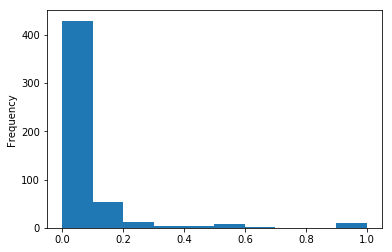

In [43]:
joint_contingency3['frac_class1'].plot(kind='hist')

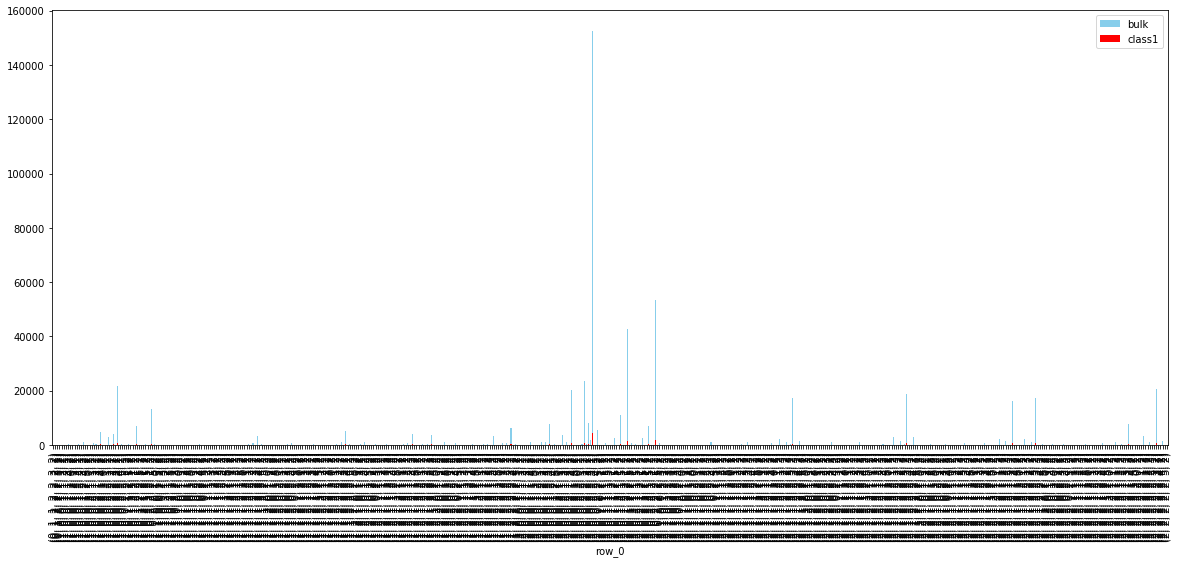

In [44]:
if True:
    fig, ax = plt.subplots(1, 1, figsize=(20, 8))
    joint_contingency3.total.plot(kind='bar', ax=ax, color='skyblue', label='bulk')
    joint_contingency3[1].plot(kind='bar', ax=ax, color='red', label='class1')
    ax.legend()

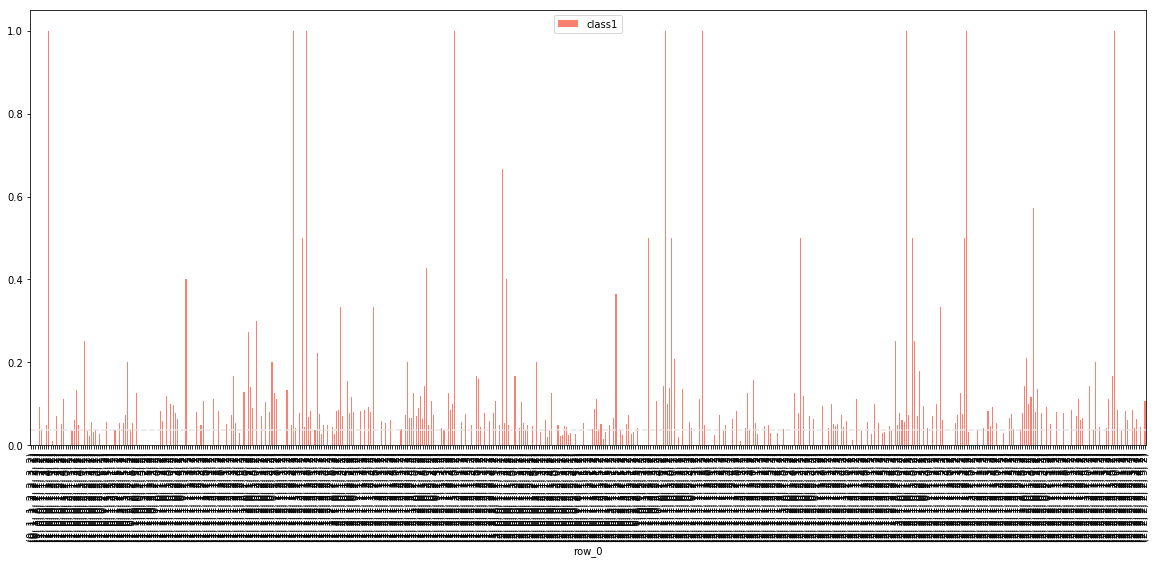

In [45]:
if True:
    fig, ax = plt.subplots(1, 1, figsize=(20, 8))
    #joint_contingency.total.plot(kind='bar', ax=ax, color='skyblue', label='bulk')
    ax.axhline(y=freq_target, color='0.9', ls='--')
    joint_contingency3['frac_class1'].plot(kind='bar', ax=ax, color='salmon', label='class1')
    ax.legend()

In [46]:
joint_contingency3.sort_values('frac_class1', ascending=False)

target                  0  1  total  allele_freq  frac_class1
row_0                                                        
(2, 2, 1, 0, 1, 3, 1)   0  1      1     0.000002     1.000000
(2, 1, 1, 1, 1, 3, 1)   0  1      1     0.000002     1.000000
(1, 2, 2, 1, 2, 5, 2)   0  1      1     0.000002     1.000000
(2, 2, 2, 2, 2, 0, 1)   0  1      1     0.000002     1.000000
(1, 1, 2, 2, 1, 3, 1)   0  1      1     0.000002     1.000000
(2, 2, 1, 1, 2, 4, 1)   0  1      1     0.000002     1.000000
(2, 1, 1, 0, 1, 2, 1)   0  1      1     0.000002     1.000000
(1, 0, 0, 1, 1, 4, 2)   0  1      1     0.000002     1.000000
(1, 1, 2, 1, 2, 4, 1)   0  1      1     0.000002     1.000000
(2, 0, 0, 1, 1, 2, 1)   1  2      3     0.000005     0.666667
(2, 2, 2, 0, 2, 0, 2)   3  4      7     0.000012     0.571429
(2, 2, 1, 1, 2, 3, 3)   1  1      2     0.000003     0.500000
(2, 1, 1, 0, 2, 0, 1)   1  1      2     0.000003     0.500000
(2, 2, 1, 0, 1, 5, 2)   1  1      2     0.000003     0.500000
(2, 1, 0, 2, 1, 3, 2)   1  1      2     0.000003     0.500000
(1, 1, 2, 2, 1, 2, 1)   1  1      2     0.000003     0.500000
(2, 1, 2, 0, 2, 2, 1)   1  1      2     0.000003     0.500000
(1, 2, 2, 0, 2, 0, 2)   4  3      7     0.000012     0.428571
(2, 0, 0, 1, 1, 3, 1)   3  2      5     0.000008     0.400000
(1, 1, 1, 1, 1, 2, 2)   3  2      5     0.000008     0.400000
(2, 0, 2, 1, 1, 5, 2)   7  4     11     0.000018     0.363636
(2, 2, 1, 1, 1, 3, 1)   2  1      3     0.000005     0.333333
(1, 2, 1, 1, 2, 4, 2)   2  1      3     0.000005     0.333333
(1, 2, 1, 0, 1, 3, 1)   2  1      3     0.000005     0.333333
(1, 1, 2, 0, 2, 0, 2)   7  3     10     0.000017     0.300000
(1, 1, 2, 0, 1, 1, 2)   8  3     11     0.000018     0.272727
(2, 2, 1, 0, 2, 0, 2)   3  1      4     0.000007     0.250000
(1, 0, 0, 2, 2, 1, 1)  12  4     16     0.000027     0.250000
(2, 1, 2, 2, 2, 5, 1)   3  1      4     0.000007     0.250000
(1, 1, 2, 2, 2, 2, 1)   7  2      9     0.000015     0.222222
...                    .. ..    ...          ...          ...
(1, 2, 2, 2, 1, 3, 1)   3  0      3     0.000005     0.000000
(1, 2, 2, 2, 1, 2, 1)   2  0      2     0.000003     0.000000
(2, 0, 2, 2, 2, 5, 1)   8  0      8     0.000013     0.000000
(1, 2, 2, 2, 1, 1, 1)   2  0      2     0.000003     0.000000
(1, 2, 2, 2, 1, 0, 2)   5  0      5     0.000008     0.000000
(1, 2, 2, 1, 2, 1, 2)  21  0     21     0.000035     0.000000
(1, 2, 2, 1, 1, 1, 2)  14  0     14     0.000024     0.000000
(1, 2, 2, 0, 2, 5, 2)   6  0      6     0.000010     0.000000
(1, 2, 2, 0, 2, 4, 2)   8  0      8     0.000013     0.000000
(1, 2, 1, 2, 2, 2, 1)   1  0      1     0.000002     0.000000
(2, 0, 0, 1, 1, 5, 2)   1  0      1     0.000002     0.000000
(2, 0, 0, 1, 2, 1, 1)  27  0     27     0.000045     0.000000
(2, 0, 0, 1, 2, 4, 1)   6  0      6     0.000010     0.000000
(2, 0, 0, 1, 2, 5, 2)   7  0      7     0.000012     0.000000
(2, 0, 2, 2, 1, 1, 1)   8  0      8     0.000013     0.000000
(2, 0, 2, 1, 2, 1, 1)   7  0      7     0.000012     0.000000
(2, 0, 2, 1, 1, 1, 1)   1  0      1     0.000002     0.000000
(2, 0, 1, 2, 2, 5, 1)   7  0      7     0.000012     0.000000
(2, 0, 1, 1, 2, 1, 1)  10  0     10     0.000017     0.000000
(0, 1, 2, 2, 2, 2, 2)   2  0      2     0.000003     0.000000
(2, 0, 1, 1, 1, 5, 1)   1  0      1     0.000002     0.000000
(2, 0, 1, 1, 1, 1, 1)   1  0      1     0.000002     0.000000
(2, 0, 1, 0, 2, 1, 2)   1  0      1     0.000002     0.000000
(2, 0, 0, 2, 2, 5, 2)  28  0     28     0.000047     0.000000
(2, 0, 0, 2, 2, 4, 1)  47  0     47     0.000079     0.000000
(2, 0, 0, 2, 2, 0, 1)   3  0      3     0.000005     0.000000
(2, 0, 0, 2, 1, 5, 2)   7  0      7     0.000012     0.000000
(2, 0, 0, 2, 1, 2, 1)   9  0      9     0.000015     0.000000
(2, 0, 0, 2, 1, 1, 1)  16  0     16     0.000027     0.000000
(2, 0, 1, 1, 1, 5, 2)  18  0     18     0.000030     0.000000

[519 rows x 5 columns]

In [47]:
car_cat_score = joint_contingency3['frac_class1'].reset_index()
#car_cat_score = (joint_contingency3['frac_class1'] / np.max(joint_contingency3['frac_class1'])).reset_index()

In [48]:
car_cat_converted = pd.DataFrame()
car_cat_converted['id'] = train['id']
car_cat_converted['car_cat_joint'] = car_cats_joint

In [49]:
car_cat_converted = pd.merge(car_cat_converted, car_cat_score, 
                     left_on='car_cat_joint', right_on='row_0', copy=False).sort_values('id', ascending=True).reset_index(drop=True)

In [50]:
car_cat_converted

id          car_cat_joint                  row_0  frac_class1
0             7  (2, 0, 2, 2, 1, 1, 2)  (2, 0, 2, 2, 1, 1, 2)     0.050438
1             9  (2, 0, 0, 2, 2, 3, 2)  (2, 0, 0, 2, 2, 3, 2)     0.028005
2            13  (2, 0, 0, 2, 2, 3, 2)  (2, 0, 0, 2, 2, 3, 2)     0.028005
3            16  (2, 1, 2, 2, 2, 4, 2)  (2, 1, 2, 2, 2, 4, 2)     0.033865
4            17  (2, 0, 0, 2, 2, 3, 2)  (2, 0, 0, 2, 2, 3, 2)     0.028005
5            19  (1, 0, 1, 2, 2, 1, 2)  (1, 0, 1, 2, 2, 1, 2)     0.036881
6            20  (2, 0, 2, 2, 2, 1, 2)  (2, 0, 2, 2, 2, 1, 2)     0.031438
7            22  (2, 1, 1, 2, 2, 3, 2)  (2, 1, 1, 2, 2, 3, 2)     0.030068
8            26  (2, 0, 2, 2, 2, 1, 2)  (2, 0, 2, 2, 2, 1, 2)     0.031438
9            28  (1, 1, 1, 2, 2, 3, 2)  (1, 1, 1, 2, 2, 3, 2)     0.053833
10           34  (2, 0, 0, 2, 2, 3, 2)  (2, 0, 0, 2, 2, 3, 2)     0.028005
11           35  (1, 0, 0, 2, 1, 1, 2)  (1, 0, 0, 2, 1, 1, 2)     0.033121
12           36  (2, 0, 0, 2, 2, 3, 2)  (2, 0, 0, 2, 2, 3, 2)     0.028005
13           43  (2, 1, 2, 2, 2, 3, 2)  (2, 1, 2, 2, 2, 3, 2)     0.031930
14           46  (2, 0, 0, 2, 2, 3, 2)  (2, 0, 0, 2, 2, 3, 2)     0.028005
15           48  (2, 0, 2, 2, 1, 1, 2)  (2, 0, 2, 2, 1, 1, 2)     0.050438
16           50  (2, 0, 0, 2, 2, 1, 2)  (2, 0, 0, 2, 2, 1, 2)     0.025167
17           58  (2, 2, 1, 2, 1, 3, 2)  (2, 2, 1, 2, 1, 3, 2)     0.045114
18           61  (2, 0, 0, 2, 2, 3, 2)  (2, 0, 0, 2, 2, 3, 2)     0.028005
19           64  (2, 0, 0, 2, 2, 3, 2)  (2, 0, 0, 2, 2, 3, 2)     0.028005
20           65  (2, 0, 0, 2, 2, 3, 2)  (2, 0, 0, 2, 2, 3, 2)     0.028005
21           66  (2, 0, 0, 2, 2, 3, 2)  (2, 0, 0, 2, 2, 3, 2)     0.028005
22           72  (1, 1, 1, 2, 2, 1, 2)  (1, 1, 1, 2, 2, 1, 2)     0.051672
23           74  (2, 0, 1, 2, 2, 1, 2)  (2, 0, 1, 2, 2, 1, 2)     0.031067
24           77  (2, 0, 1, 2, 2, 1, 2)  (2, 0, 1, 2, 2, 1, 2)     0.031067
25           78  (2, 0, 2, 2, 2, 1, 2)  (2, 0, 2, 2, 2, 1, 2)     0.031438
26           79  (2, 0, 2, 2, 1, 1, 2)  (2, 0, 2, 2, 1, 1, 2)     0.050438
27           80  (2, 0, 1, 2, 2, 1, 2)  (2, 0, 1, 2, 2, 1, 2)     0.031067
28           84  (1, 0, 2, 2, 2, 1, 2)  (1, 0, 2, 2, 2, 1, 2)     0.038997
29           85  (1, 0, 2, 2, 2, 1, 2)  (1, 0, 2, 2, 2, 1, 2)     0.038997
...         ...                    ...                    ...          ...
595182  1487945  (2, 0, 2, 1, 2, 1, 2)  (2, 0, 2, 1, 2, 1, 2)     0.036377
595183  1487951  (2, 0, 0, 2, 2, 3, 2)  (2, 0, 0, 2, 2, 3, 2)     0.028005
595184  1487952  (2, 0, 0, 1, 2, 3, 2)  (2, 0, 0, 1, 2, 3, 2)     0.048143
595185  1487954  (2, 2, 1, 2, 1, 3, 2)  (2, 2, 1, 2, 1, 3, 2)     0.045114
595186  1487957  (2, 1, 1, 2, 1, 3, 2)  (2, 1, 1, 2, 1, 3, 2)     0.039168
595187  1487958  (2, 0, 2, 1, 2, 1, 2)  (2, 0, 2, 1, 2, 1, 2)     0.036377
595188  1487962  (2, 0, 0, 2, 2, 3, 2)  (2, 0, 0, 2, 2, 3, 2)     0.028005
595189  1487963  (2, 1, 2, 2, 2, 1, 2)  (2, 1, 2, 2, 2, 1, 2)     0.025492
595190  1487964  (2, 0, 2, 2, 2, 1, 2)  (2, 0, 2, 2, 2, 1, 2)     0.031438
595191  1487968  (2, 0, 0, 2, 2, 3, 2)  (2, 0, 0, 2, 2, 3, 2)     0.028005
595192  1487973  (2, 0, 0, 2, 1, 3, 2)  (2, 0, 0, 2, 1, 3, 2)     0.033590
595193  1487975  (1, 1, 1, 0, 1, 3, 2)  (1, 1, 1, 0, 1, 3, 2)     0.119048
595194  1487976  (2, 1, 1, 2, 2, 3, 2)  (2, 1, 1, 2, 2, 3, 2)     0.030068
595195  1487980  (1, 2, 1, 2, 1, 3, 2)  (1, 2, 1, 2, 1, 3, 2)     0.059879
595196  1487983  (2, 0, 0, 1, 2, 3, 2)  (2, 0, 0, 1, 2, 3, 2)     0.048143
595197  1487988  (2, 0, 0, 2, 2, 3, 2)  (2, 0, 0, 2, 2, 3, 2)     0.028005
595198  1487990  (2, 2, 2, 2, 2, 3, 2)  (2, 2, 2, 2, 2, 3, 2)     0.039930
595199  1487992  (2, 2, 1, 2, 1, 3, 2)  (2, 2, 1, 2, 1, 3, 2)     0.045114
595200  1487994  (2, 0, 0, 2, 2, 3, 2)  (2, 0, 0, 2, 2, 3, 2)     0.028005
595201  1487996  (2, 1, 1, 2, 2, 3, 2)  (2, 1, 1, 2, 2, 3, 2)     0.030068
595202  1488001  (2, 1, 2, 2, 2, 1, 2)  (2, 1, 2, 2, 2, 1, 2)     0.025492
595203  1488005  (2, 2, 1, 2, 1, 3, 2)

In [51]:
car_cats_joint2 = car_cats[car_cats_big_fs].apply(tuple, axis=1)
len(car_cats_joint2.unique())

2154

In [52]:
joint_contingency3_1 = pd.crosstab(car_cats_joint2, target)
joint_contingency3_1['total'] = joint_contingency3_1[0] + joint_contingency3_1[1]
joint_contingency3_1['allele_freq'] = joint_contingency3_1['total'] / num_samples
joint_contingency3_1['frac_class1'] = joint_contingency3_1[1]/joint_contingency3_1['total']
#joint_contingency3_1

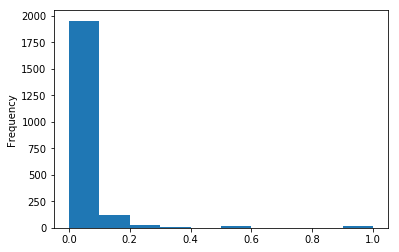

In [53]:
joint_contingency3_1['frac_class1'].plot(kind='hist')

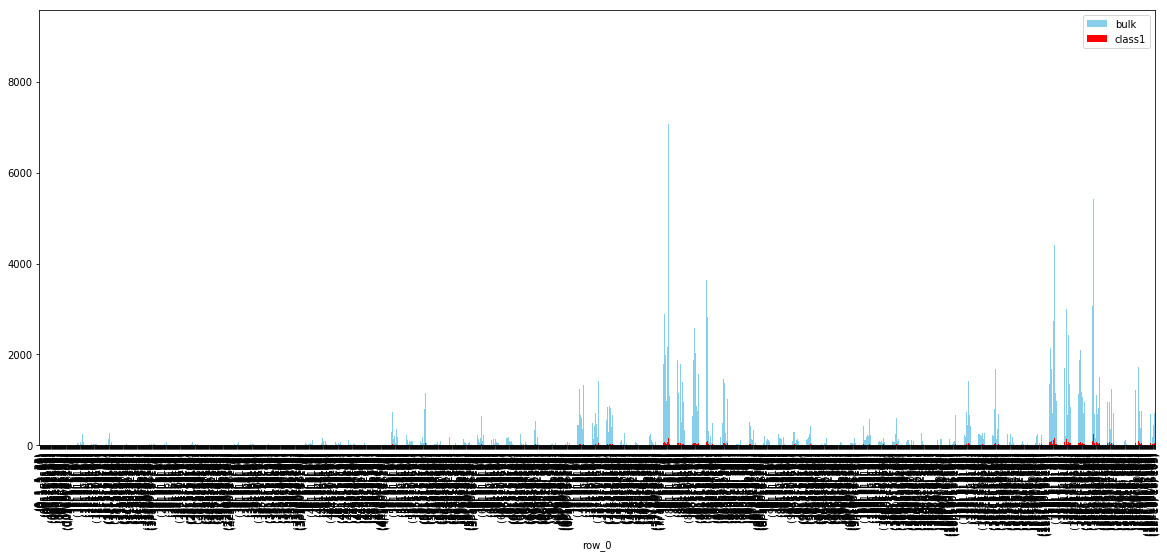

In [54]:
if True:
    fig, ax = plt.subplots(1, 1, figsize=(20, 8))
    joint_contingency3_1.total.plot(kind='bar', ax=ax, color='skyblue', label='bulk')
    joint_contingency3_1[1].plot(kind='bar', ax=ax, color='red', label='class1')
    ax.legend()

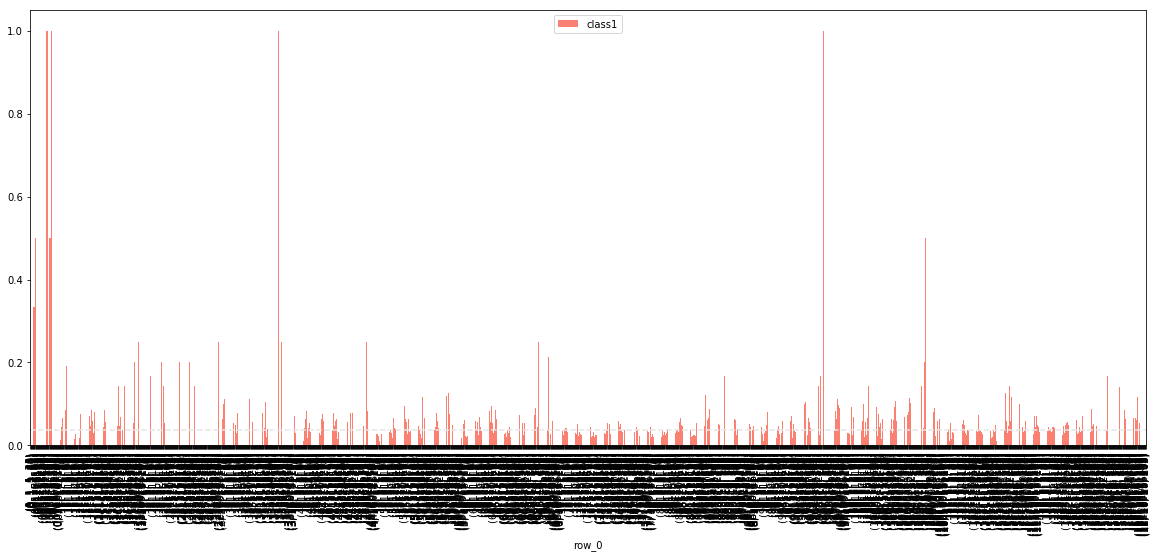

In [55]:
if True:
    fig, ax = plt.subplots(1, 1, figsize=(20, 8))
    #joint_contingency.total.plot(kind='bar', ax=ax, color='skyblue', label='bulk')
    ax.axhline(y=freq_target, color='0.9', ls='--')
    joint_contingency3_1['frac_class1'].plot(kind='bar', ax=ax, color='salmon', label='class1')
    ax.legend()

In [56]:
joint_contingency3_1.sort_values('frac_class1', ascending=False)

target             0  1  total  allele_freq  frac_class1
row_0                                                   
(0, 3, 2, 91)      0  1      1     0.000002     1.000000
(0, 10, 1, 105)    0  2      2     0.000003     1.000000
(0, 2, 18, 105)    0  1      1     0.000002     1.000000
(0, 1, 16, 64)     0  1      1     0.000002     1.000000
(0, 1, 16, 6)      0  1      1     0.000002     1.000000
(0, 6, 15, 105)    0  1      1     0.000002     1.000000
(0, 7, 2, 105)     0  1      1     0.000002     1.000000
(12, 7, 8, 105)    0  1      1     0.000002     1.000000
(9, 8, 15, 105)    0  1      1     0.000002     1.000000
(0, 9, 5, 105)     0  1      1     0.000002     1.000000
(4, 8, 18, 105)    0  1      1     0.000002     1.000000
(0, 2, 10, 105)    0  1      1     0.000002     1.000000
(2, 10, 16, 42)    0  1      1     0.000002     1.000000
(0, 2, 8, 105)     0  1      1     0.000002     1.000000
(2, 9, 4, 105)     0  1      1     0.000002     1.000000
(1, 5, 11, 105)    0  1      1     0.000002     1.000000
(3, 3, 5, 105)     0  1      1     0.000002     1.000000
(2, 1, 10, 105)    0  1      1     0.000002     1.000000
(9, 5, 11, 105)    0  1      1     0.000002     1.000000
(2, 1, 7, 34)      1  2      3     0.000005     0.666667
(2, 9, 2, 105)     1  2      3     0.000005     0.666667
(0, 3, 2, 105)     5  5     10     0.000017     0.500000
(7, 6, 2, 105)     1  1      2     0.000003     0.500000
(0, 3, 1, 101)     1  1      2     0.000003     0.500000
(10, 8, 16, 105)   2  2      4     0.000007     0.500000
(0, 3, 5, 105)     3  3      6     0.000010     0.500000
(0, 3, 7, 105)     5  5     10     0.000017     0.500000
(1, 10, 2, 105)    1  1      2     0.000003     0.500000
(0, 10, 18, 105)   2  2      4     0.000007     0.500000
(0, 10, 16, 59)    1  1      2     0.000003     0.500000
...               .. ..    ...          ...          ...
(9, 1, 15, 9)     38  0     38     0.000064     0.000000
(2, 3, 12, 95)    10  0     10     0.000017     0.000000
(9, 1, 1, 24)     14  0     14     0.000024     0.000000
(2, 9, 14, 5)      1  0      1     0.000002     0.000000
(2, 9, 5, 105)     6  0      6     0.000010     0.000000
(8, 7, 8, 105)     2  0      2     0.000003     0.000000
(2, 9, 12, 72)     3  0      3     0.000005     0.000000
(8, 8, 1, 105)     1  0      1     0.000002     0.000000
(8, 8, 2, 105)     4  0      4     0.000007     0.000000
(8, 8, 15, 105)    4  0      4     0.000007     0.000000
(2, 9, 12, 25)     3  0      3     0.000005     0.000000
(8, 8, 18, 105)    4  0      4     0.000007     0.000000
(2, 9, 8, 105)     3  0      3     0.000005     0.000000
(2, 9, 6, 105)     4  0      4     0.000007     0.000000
(8, 9, 7, 105)    13  0     13     0.000022     0.000000
(8, 9, 9, 105)    12  0     12     0.000020     0.000000
(8, 9, 16, 105)    2  0      2     0.000003     0.000000
(2, 7, 2, 105)     3  0      3     0.000005     0.000000
(8, 9, 18, 105)   10  0     10     0.000017     0.000000
(2, 9, 5, 7)       4  0      4     0.000007     0.000000
(2, 8, 2, 105)     1  0      1     0.000002     0.000000
(8, 10, 4, 105)    9  0      9     0.000015     0.000000
(8, 10, 6, 105)    2  0      2     0.000003     0.000000
(8, 10, 8, 105)    1  0      1     0.000002     0.000000
(2, 7, 18, 105)    1  0      1     0.000002     0.000000
(8, 10, 12, 105)  15  0     15     0.000025     0.000000
(2, 7, 16, 105)    1  0      1     0.000002     0.000000
(2, 7, 12, 105)    1  0      1     0.000002     0.000000
(2, 7, 5, 105)     1  0      1     0.000002     0.000000
(0, 1, 1, 33)      1  0      1     0.000002     0.000000

[2154 rows x 5 columns]

In [57]:
car_cat_score2 = joint_contingency3_1['frac_class1'].reset_index()
#car_cat_score = (joint_contingency3['frac_class1'] / np.max(joint_contingency3['frac_class1'])).reset_index()

In [58]:
car_cat_converted2 = pd.DataFrame()
car_cat_converted2['id'] = train['id']
car_cat_converted2['car_cat_joint'] = car_cats_joint2

In [59]:
car_cat_converted2 = pd.merge(car_cat_converted2, car_cat_score2, 
                     left_on='car_cat_joint', right_on='row_0', copy=False).sort_values('id', ascending=True).reset_index(drop=True)

In [60]:
car_cat_converted2

id     car_cat_joint             row_0  frac_class1
0             7    (11, 1, 5, 13)    (11, 1, 5, 13)     0.032401
1             9   (12, 1, 12, 20)   (12, 1, 12, 20)     0.026249
2            13    (8, 1, 15, 61)    (8, 1, 15, 61)     0.023227
3            16   (8, 1, 12, 105)   (8, 1, 12, 105)     0.023859
4            17   (12, 1, 15, 83)   (12, 1, 15, 83)     0.030589
5            19  (11, 1, 15, 105)  (11, 1, 15, 105)     0.017937
6            20   (7, 1, 12, 100)   (7, 1, 12, 100)     0.020545
7            22   (12, 1, 12, 31)   (12, 1, 12, 31)     0.033654
8            26   (11, 1, 15, 69)   (11, 1, 15, 69)     0.033846
9            28  (12, 2, 15, 105)  (12, 2, 15, 105)     0.053022
10           34   (12, 9, 14, 21)   (12, 9, 14, 21)     0.055614
11           35   (12, 1, 12, 37)   (12, 1, 12, 37)     0.037843
12           36   (7, 1, 12, 102)   (7, 1, 12, 102)     0.035510
13           43   (10, 1, 7, 105)   (10, 1, 7, 105)     0.032895
14           46  (12, 1, 12, 104)  (12, 1, 12, 104)     0.028895
15           48   (7, 10, 16, 42)   (7, 10, 16, 42)     0.071090
16           50    (12, 2, 4, 60)    (12, 2, 4, 60)     0.033735
17           58  (12, 1, 12, 105)  (12, 1, 12, 105)     0.034779
18           61     (8, 1, 1, 44)     (8, 1, 1, 44)     0.017170
19           64     (8, 1, 2, 65)     (8, 1, 2, 65)     0.024770
20           65   (12, 1, 15, 83)   (12, 1, 15, 83)     0.030589
21           66   (8, 1, 12, 104)   (8, 1, 12, 104)     0.023345
22           72    (6, 1, 15, 30)    (6, 1, 15, 30)     0.045455
23           74     (7, 1, 1, 96)     (7, 1, 1, 96)     0.023256
24           77    (5, 1, 2, 105)    (5, 1, 2, 105)     0.044693
25           78    (5, 9, 12, 25)    (5, 9, 12, 25)     0.048458
26           79    (11, 1, 16, 6)    (11, 1, 16, 6)     0.036554
27           80   (5, 1, 12, 100)   (5, 1, 12, 100)     0.016311
28           84    (5, 1, 7, 105)    (5, 1, 7, 105)     0.055556
29           85    (9, 1, 11, 29)    (9, 1, 11, 29)     0.026667
...         ...               ...               ...          ...
595182  1487945     (7, 1, 2, 11)     (7, 1, 2, 11)     0.024077
595183  1487951     (8, 1, 2, 65)     (8, 1, 2, 65)     0.024770
595184  1487952    (8, 3, 12, 15)    (8, 3, 12, 15)     0.031802
595185  1487954     (8, 1, 2, 39)     (8, 1, 2, 39)     0.025082
595186  1487957    (12, 1, 1, 88)    (12, 1, 1, 88)     0.037104
595187  1487958    (7, 3, 7, 105)    (7, 3, 7, 105)     0.090909
595188  1487962    (12, 1, 1, 38)    (12, 1, 1, 38)     0.035466
595189  1487963    (8, 1, 12, 17)    (8, 1, 12, 17)     0.020147
595190  1487964     (7, 1, 2, 65)     (7, 1, 2, 65)     0.024425
595191  1487968    (12, 1, 1, 96)    (12, 1, 1, 96)     0.031142
595192  1487973    (8, 1, 15, 83)    (8, 1, 15, 83)     0.020358
595193  1487975  (12, 1, 12, 105)  (12, 1, 12, 105)     0.034779
595194  1487976    (8, 1, 12, 58)    (8, 1, 12, 58)     0.024936
595195  1487980    (5, 1, 12, 48)    (5, 1, 12, 48)     0.045455
595196  1487983    (8, 3, 12, 15)    (8, 3, 12, 15)     0.031802
595197  1487988   (12, 2, 4, 103)   (12, 2, 4, 103)     0.037214
595198  1487990  (12, 1, 12, 102)  (12, 1, 12, 102)     0.041156
595199  1487992   (12, 1, 12, 18)   (12, 1, 12, 18)     0.052899
595200  1487994    (8, 1, 15, 50)    (8, 1, 15, 50)     0.029393
595201  1487996   (12, 1, 12, 20)   (12, 1, 12, 20)     0.026249
595202  1488001   (10, 1, 12, 54)   (10, 1, 12, 54)     0.016393
595203  1488005    (8, 1, 15, 73)    (8, 1, 15, 73)     0.054096
595204  1488008     (7, 1, 7, 28)     (7, 1, 7, 28)     0.033195
595205  1488009     (6, 1, 7, 27)     (6, 1, 7, 27)     0.028571
595206  1488011    (8, 9, 14, 21)    (8, 9, 14, 21)     0.039841
595207  1488013    (11, 1, 2, 32)    (11, 1, 2, 32)     0.035714
595208  1488016   (10, 1, 16, 64)   (10, 1, 16, 64)     0.060000
595209  1488017     (8, 1, 2, 32)     (8, 1, 2, 32)     0.033016
595210  1488021  (12, 1, 12, 102)  (12, 1, 12, 102)     0.041156
595211  1488027     (8, 1, 1, 35)     (8, 1, 1, 

### Ind categoricals

In [61]:
for i, f in enumerate(ind_cats_fs):
    print('%s: %d unique vals' % (f, len(ind_cats[f].unique())))

ps_ind_02_cat: 5 unique vals
ps_ind_04_cat: 3 unique vals
ps_ind_05_cat: 8 unique vals


In [62]:
ind_cats_joint = ind_cats.apply(tuple, axis=1)
len(ind_cats_joint.unique())

70

In [63]:
joint_contingency4 = pd.crosstab(ind_cats_joint, target)
joint_contingency4['total'] = joint_contingency4[0] + joint_contingency4[1]
joint_contingency4['allele_freq'] = joint_contingency4['total'] / num_samples
joint_contingency4['frac_class1'] = joint_contingency4[1]/joint_contingency4['total']
joint_contingency4

target          0     1   total  allele_freq  frac_class1
row_0                                                    
(0, 0, 0)      46    33      79     0.000133     0.417722
(0, 1, 0)       1     0       1     0.000002     0.000000
(0, 1, 1)      58     3      61     0.000102     0.049180
(0, 1, 7)       2     1       3     0.000005     0.333333
(0, 2, 0)       1     0       1     0.000002     0.000000
(0, 2, 1)      67     3      70     0.000118     0.042857
(0, 2, 5)       1     0       1     0.000002     0.000000
(2, 0, 1)       4     0       4     0.000007     0.000000
(2, 1, 0)     355    12     367     0.000617     0.032698
(2, 1, 1)  231062  7610  238672     0.400987     0.031885
(2, 1, 2)    4176   190    4366     0.007335     0.043518
(2, 1, 3)    1781   127    1908     0.003206     0.066562
(2, 1, 4)    4430   173    4603     0.007733     0.037584
(2, 1, 5)    7414   350    7764     0.013044     0.045080
(2, 1, 6)     875    39     914     0.001536     0.042670
(2, 1, 7)    8163   465    8628     0.014496     0.053894
(2, 2, 0)     324    17     341     0.000573     0.049853
(2, 2, 1)  140390  5242  145632     0.244672     0.035995
(2, 2, 2)    2028   126    2154     0.003619     0.058496
(2, 2, 3)    1511   147    1658     0.002786     0.088661
(2, 2, 4)    1867   112    1979     0.003325     0.056594
(2, 2, 5)    5722   376    6098     0.010245     0.061660
(2, 2, 6)     420    32     452     0.000759     0.070796
(2, 2, 7)    5909   410    6319     0.010616     0.064884
(3, 1, 0)    2789   245    3034     0.005097     0.080751
(3, 1, 1)   55390  2059   57449     0.096519     0.035840
(3, 1, 2)     655    34     689     0.001158     0.049347
(3, 1, 3)     134     9     143     0.000240     0.062937
(3, 1, 4)     573    29     602     0.001011     0.048173
(3, 1, 5)     496    31     527     0.000885     0.058824
...           ...   ...     ...          ...          ...
(4, 1, 0)       5     0       5     0.000008     0.000000
(4, 1, 1)    9623   340    9963     0.016739     0.034126
(4, 1, 2)     113     4     117     0.000197     0.034188
(4, 1, 3)      35     4      39     0.000066     0.102564
(4, 1, 4)      79     4      83     0.000139     0.048193
(4, 1, 5)     118     4     122     0.000205     0.032787
(4, 1, 6)      26     2      28     0.000047     0.071429
(4, 1, 7)     181    11     192     0.000323     0.057292
(4, 2, 0)       5     0       5     0.000008     0.000000
(4, 2, 1)   14531   540   15071     0.025320     0.035830
(4, 2, 2)     317    11     328     0.000551     0.033537
(4, 2, 3)     148    10     158     0.000265     0.063291
(4, 2, 4)     308    16     324     0.000544     0.049383
(4, 2, 5)     815    43     858     0.001442     0.050117
(4, 2, 6)      60     2      62     0.000104     0.032258
(4, 2, 7)     773    58     831     0.001396     0.069795
(5, 1, 1)    2736   101    2837     0.004766     0.035601
(5, 1, 2)      33     4      37     0.000062     0.108108
(5, 1, 3)      11     1      12     0.000020     0.083333
(5, 1, 4)      38     0      38     0.000064     0.000000
(5, 1, 5)      55     3      58     0.000097     0.051724
(5, 1, 6)       3     0       3     0.000005     0.000000
(5, 1, 7)      67     4      71     0.000119     0.056338
(5, 2, 1)    7119   289    7408     0.012446     0.039012
(5, 2, 2)      80     5      85     0.000143     0.058824
(5, 2, 3)      73     7      80     0.000134     0.087500
(5, 2, 4)      83     8      91     0.000153     0.087912
(5, 2, 5)     288    18     306     0.000514     0.058824
(5, 2, 6)      17     0      17     0.000029     0.000000
(5, 2, 7)     311    24     335     0.000563     0.071642

[70 rows x 5 columns]

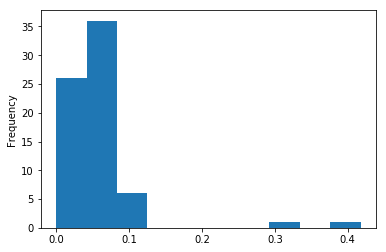

In [64]:
joint_contingency4['frac_class1'].plot(kind='hist')

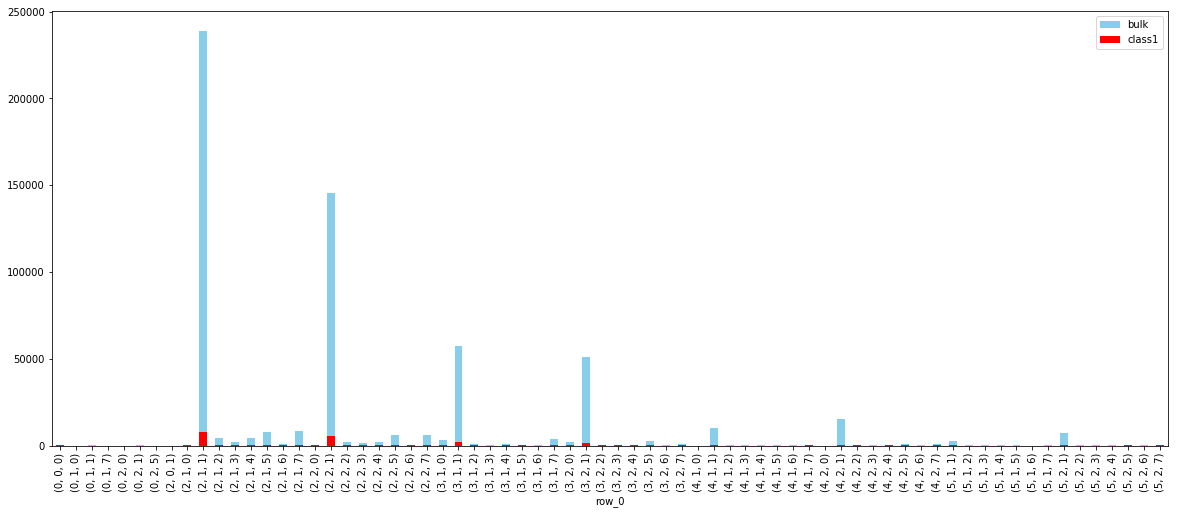

In [65]:
fig, ax = plt.subplots(1, 1, figsize=(20, 8))
joint_contingency4.total.plot(kind='bar', ax=ax, color='skyblue', label='bulk')
joint_contingency4[1].plot(kind='bar', ax=ax, color='red', label='class1')
ax.legend()

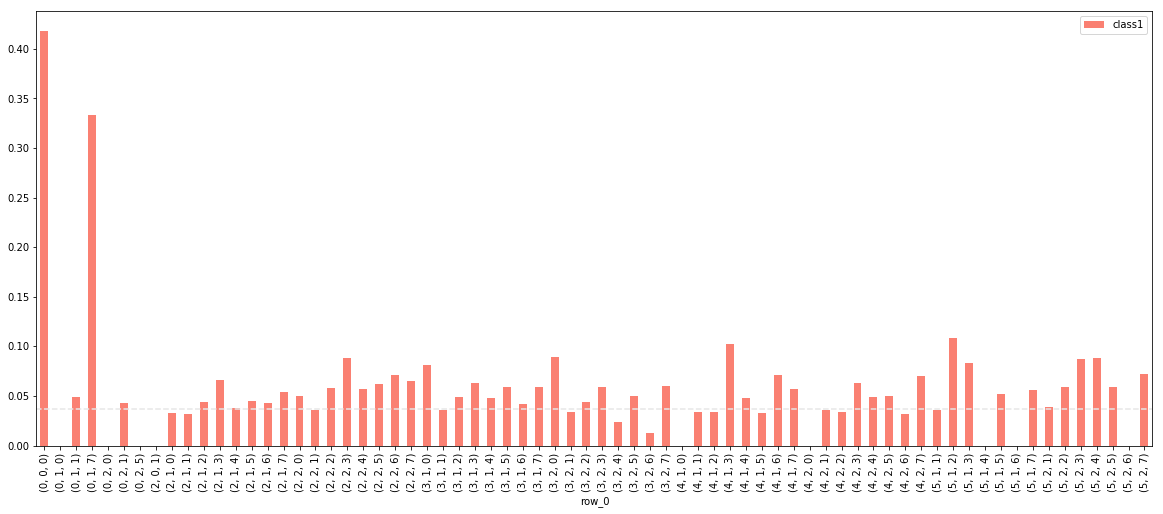

In [66]:
fig, ax = plt.subplots(1, 1, figsize=(20, 8))
#joint_contingency.total.plot(kind='bar', ax=ax, color='skyblue', label='bulk')
ax.axhline(y=freq_target, color='0.9', ls='--')
joint_contingency4['frac_class1'].plot(kind='bar', ax=ax, color='salmon', label='class1')
ax.legend()

In [67]:
joint_contingency4.sort_values('frac_class1', ascending=False)

target          0     1   total  allele_freq  frac_class1
row_0                                                    
(0, 0, 0)      46    33      79     0.000133     0.417722
(0, 1, 7)       2     1       3     0.000005     0.333333
(5, 1, 2)      33     4      37     0.000062     0.108108
(4, 1, 3)      35     4      39     0.000066     0.102564
(3, 2, 0)    1799   177    1976     0.003320     0.089575
(2, 2, 3)    1511   147    1658     0.002786     0.088661
(5, 2, 4)      83     8      91     0.000153     0.087912
(5, 2, 3)      73     7      80     0.000134     0.087500
(5, 1, 3)      11     1      12     0.000020     0.083333
(3, 1, 0)    2789   245    3034     0.005097     0.080751
(5, 2, 7)     311    24     335     0.000563     0.071642
(4, 1, 6)      26     2      28     0.000047     0.071429
(2, 2, 6)     420    32     452     0.000759     0.070796
(4, 2, 7)     773    58     831     0.001396     0.069795
(2, 1, 3)    1781   127    1908     0.003206     0.066562
(2, 2, 7)    5909   410    6319     0.010616     0.064884
(4, 2, 3)     148    10     158     0.000265     0.063291
(3, 1, 3)     134     9     143     0.000240     0.062937
(2, 2, 5)    5722   376    6098     0.010245     0.061660
(3, 2, 7)     705    45     750     0.001260     0.060000
(3, 2, 3)     175    11     186     0.000312     0.059140
(3, 1, 7)    3325   208    3533     0.005936     0.058873
(3, 1, 5)     496    31     527     0.000885     0.058824
(5, 2, 5)     288    18     306     0.000514     0.058824
(5, 2, 2)      80     5      85     0.000143     0.058824
(2, 2, 2)    2028   126    2154     0.003619     0.058496
(4, 1, 7)     181    11     192     0.000323     0.057292
(2, 2, 4)    1867   112    1979     0.003325     0.056594
(5, 1, 7)      67     4      71     0.000119     0.056338
(2, 1, 7)    8163   465    8628     0.014496     0.053894
...           ...   ...     ...          ...          ...
(3, 2, 2)     522    24     546     0.000917     0.043956
(2, 1, 2)    4176   190    4366     0.007335     0.043518
(0, 2, 1)      67     3      70     0.000118     0.042857
(2, 1, 6)     875    39     914     0.001536     0.042670
(3, 1, 6)      92     4      96     0.000161     0.041667
(5, 2, 1)    7119   289    7408     0.012446     0.039012
(2, 1, 4)    4430   173    4603     0.007733     0.037584
(2, 2, 1)  140390  5242  145632     0.244672     0.035995
(3, 1, 1)   55390  2059   57449     0.096519     0.035840
(4, 2, 1)   14531   540   15071     0.025320     0.035830
(5, 1, 1)    2736   101    2837     0.004766     0.035601
(4, 1, 2)     113     4     117     0.000197     0.034188
(4, 1, 1)    9623   340    9963     0.016739     0.034126
(4, 2, 2)     317    11     328     0.000551     0.033537
(3, 2, 1)   49148  1694   50842     0.085418     0.033319
(4, 1, 5)     118     4     122     0.000205     0.032787
(2, 1, 0)     355    12     367     0.000617     0.032698
(4, 2, 6)      60     2      62     0.000104     0.032258
(2, 1, 1)  231062  7610  238672     0.400987     0.031885
(3, 2, 4)     501    12     513     0.000862     0.023392
(3, 2, 6)      76     1      77     0.000129     0.012987
(0, 2, 5)       1     0       1     0.000002     0.000000
(4, 2, 0)       5     0       5     0.000008     0.000000
(5, 1, 4)      38     0      38     0.000064     0.000000
(2, 0, 1)       4     0       4     0.000007     0.000000
(5, 1, 6)       3     0       3     0.000005     0.000000
(0, 1, 0)       1     0       1     0.000002     0.000000
(0, 2, 0)       1     0       1     0.000002     0.000000
(5, 2, 6)      17     0      17     0.000029     0.000000
(4, 1, 0)       5     0       5     0.000008     0.000000

[70 rows x 5 columns]

In [68]:
ind_cat_score = joint_contingency4['frac_class1'].reset_index()
#ind_cat_score = (joint_contingency4['frac_class1'] / np.max(joint_contingency4['frac_class1'])).reset_index()

In [69]:
ind_cat_converted = pd.DataFrame()
ind_cat_converted['id'] = train['id']
ind_cat_converted['ind_cat_joint'] = ind_cats_joint

In [70]:
ind_cat_converted = pd.merge(ind_cat_converted, ind_cat_score, 
                     left_on='ind_cat_joint', right_on='row_0', copy=False).sort_values('id', ascending=True).reset_index(drop=True)

In [71]:
ind_cat_converted

id ind_cat_joint      row_0  frac_class1
0             7     (3, 2, 1)  (3, 2, 1)     0.033319
1             9     (2, 1, 1)  (2, 1, 1)     0.031885
2            13     (5, 2, 1)  (5, 2, 1)     0.039012
3            16     (2, 1, 1)  (2, 1, 1)     0.031885
4            17     (3, 2, 1)  (3, 2, 1)     0.033319
5            19     (2, 1, 1)  (2, 1, 1)     0.031885
6            20     (2, 2, 1)  (2, 2, 1)     0.035995
7            22     (2, 1, 1)  (2, 1, 1)     0.031885
8            26     (2, 2, 1)  (2, 2, 1)     0.035995
9            28     (2, 1, 1)  (2, 1, 1)     0.031885
10           34     (3, 1, 1)  (3, 1, 1)     0.035840
11           35     (2, 2, 1)  (2, 2, 1)     0.035995
12           36     (2, 2, 1)  (2, 2, 1)     0.035995
13           43     (2, 2, 1)  (2, 2, 1)     0.035995
14           46     (2, 1, 1)  (2, 1, 1)     0.031885
15           48     (2, 2, 1)  (2, 2, 1)     0.035995
16           50     (3, 1, 1)  (3, 1, 1)     0.035840
17           58     (2, 1, 2)  (2, 1, 2)     0.043518
18           61     (2, 1, 1)  (2, 1, 1)     0.031885
19           64     (2, 2, 1)  (2, 2, 1)     0.035995
20           65     (2, 1, 1)  (2, 1, 1)     0.031885
21           66     (2, 2, 5)  (2, 2, 5)     0.061660
22           72     (4, 2, 4)  (4, 2, 4)     0.049383
23           74     (2, 2, 1)  (2, 2, 1)     0.035995
24           77     (2, 1, 1)  (2, 1, 1)     0.031885
25           78     (2, 1, 1)  (2, 1, 1)     0.031885
26           79     (2, 2, 1)  (2, 2, 1)     0.035995
27           80     (2, 1, 1)  (2, 1, 1)     0.031885
28           84     (3, 2, 5)  (3, 2, 5)     0.049808
29           85     (3, 1, 1)  (3, 1, 1)     0.035840
...         ...           ...        ...          ...
595182  1487945     (2, 1, 1)  (2, 1, 1)     0.031885
595183  1487951     (2, 1, 1)  (2, 1, 1)     0.031885
595184  1487952     (2, 1, 1)  (2, 1, 1)     0.031885
595185  1487954     (3, 2, 1)  (3, 2, 1)     0.033319
595186  1487957     (2, 2, 1)  (2, 2, 1)     0.035995
595187  1487958     (2, 1, 5)  (2, 1, 5)     0.045080
595188  1487962     (2, 1, 1)  (2, 1, 1)     0.031885
595189  1487963     (2, 1, 1)  (2, 1, 1)     0.031885
595190  1487964     (3, 1, 1)  (3, 1, 1)     0.035840
595191  1487968     (2, 1, 1)  (2, 1, 1)     0.031885
595192  1487973     (2, 1, 1)  (2, 1, 1)     0.031885
595193  1487975     (3, 1, 0)  (3, 1, 0)     0.080751
595194  1487976     (2, 2, 1)  (2, 2, 1)     0.035995
595195  1487980     (4, 2, 1)  (4, 2, 1)     0.035830
595196  1487983     (2, 1, 1)  (2, 1, 1)     0.031885
595197  1487988     (2, 2, 1)  (2, 2, 1)     0.035995
595198  1487990     (2, 2, 1)  (2, 2, 1)     0.035995
595199  1487992     (2, 2, 1)  (2, 2, 1)     0.035995
595200  1487994     (2, 1, 4)  (2, 1, 4)     0.037584
595201  1487996     (3, 2, 1)  (3, 2, 1)     0.033319
595202  1488001     (2, 1, 1)  (2, 1, 1)     0.031885
595203  1488005     (3, 2, 1)  (3, 2, 1)     0.033319
595204  1488008     (3, 2, 1)  (3, 2, 1)     0.033319
595205  1488009     (4, 2, 1)  (4, 2, 1)     0.035830
595206  1488011     (2, 1, 1)  (2, 1, 1)     0.031885
595207  1488013     (2, 1, 1)  (2, 1, 1)     0.031885
595208  1488016     (2, 1, 1)  (2, 1, 1)     0.031885
595209  1488017     (2, 1, 1)  (2, 1, 1)     0.031885
595210  1488021     (3, 2, 1)  (3, 2, 1)     0.033319
595211  1488027     (2, 1, 1)  (2, 1, 1)     0.031885

[595212 rows x 4 columns]

# Continuous/Ordinals

In [85]:
%%time
contord_converted = ps.convertOrdinalFeatures(cont_ordinals, target, verbose=True)

Processing ps_calc_01
Processing ps_calc_02
Processing ps_calc_03
Processing ps_calc_04
Processing ps_calc_05
Processing ps_calc_06
Processing ps_calc_07
Processing ps_calc_08
Processing ps_calc_09
Processing ps_calc_10
Processing ps_calc_11
Processing ps_calc_12
Processing ps_calc_13
Processing ps_calc_14
Processing ps_car_11
Processing ps_car_12
Processing ps_car_13
Processing ps_car_14
Processing ps_car_15
Processing ps_ind_01
Processing ps_ind_03
Processing ps_ind_14
Processing ps_ind_15
Processing ps_reg_01
Processing ps_reg_02
Processing ps_reg_03
CPU times: user 3min 23s, sys: 9.12 s, total: 3min 32s
Wall time: 3min 30s


In [86]:
# Convert back to probability
contord_converted = ((contord_converted/100) + 1) * freq_target

In [87]:
contord_converted

ps_calc_01  ps_calc_02  ps_calc_03  ps_calc_04  ps_calc_05  \
0         0.036460    0.036653    0.036569    0.036238    0.036416   
1         0.036705    0.035906    0.036934    0.036815    0.036416   
2         0.037187    0.036696    0.035805    0.036815    0.036599   
3         0.036460    0.036205    0.035805    0.036815    0.036617   
4         0.037041    0.036908    0.035256    0.036815    0.036599   
5         0.036604    0.036588    0.036847    0.036238    0.036416   
6         0.036006    0.036908    0.036654    0.036815    0.036599   
7         0.035450    0.036653    0.035805    0.036393    0.036599   
8         0.036925    0.036588    0.036343    0.036238    0.036416   
9         0.036604    0.036588    0.036995    0.036815    0.036599   
10        0.036247    0.035906    0.035256    0.036815    0.036090   
11        0.036705    0.036696    0.036654    0.036815    0.036599   
12        0.036604    0.036588    0.036817    0.036058    0.036416   
13        0.036247    0.036696    0.036343    0.036815    0.036416   
14        0.037041    0.037046    0.035805    0.036238    0.036416   
15        0.037187    0.037046    0.036569    0.036815    0.036416   
16        0.036705    0.035210    0.036934    0.036815    0.036416   
17        0.036006    0.036908    0.035805    0.036393    0.036090   
18        0.037041    0.036813    0.036934    0.036238    0.036416   
19        0.036604    0.036813    0.036569    0.036815    0.036599   
20        0.036247    0.036908    0.036995    0.036393    0.036617   
21        0.036705    0.036696    0.035805    0.036238    0.036599   
22        0.035832    0.036908    0.036343    0.036238    0.036599   
23        0.036705    0.036696    0.036343    0.036815    0.036416   
24        0.036006    0.036617    0.036934    0.036815    0.036416   
25        0.037187    0.036696    0.036343    0.036815    0.036599   
26        0.036925    0.036653    0.036569    0.036058    0.036599   
27        0.036604    0.035906    0.036654    0.036815    0.036416   
28        0.036247    0.037046    0.035805    0.036815    0.036599   
29        0.036925    0.036813    0.036343    0.036815    0.036090   
...            ...         ...         ...         ...         ...   
595182    0.036705    0.035906    0.036391    0.035856    0.036599   
595183    0.035450    0.036617    0.036817    0.036058    0.036234   
595184    0.037187    0.036696    0.036391    0.036815    0.036416   
595185    0.036247    0.036205    0.036934    0.036815    0.036234   
595186    0.035832    0.035210    0.035256    0.036238    0.036599   
595187    0.036705    0.036813    0.036847    0.036058    0.036416   
595188    0.035832    0.036205    0.036934    0.036393    0.036599   
595189    0.036705    0.036205    0.036391    0.036393    0.036416   
595190    0.036604    0.036617    0.035256    0.036393    0.036090   
595191    0.037187    0.036696    0.036343    0.036815    0.036599   
595192    0.036604    0.036653    0.036817    0.036238    0.036416   
595193    0.037187    0.036588    0.035256    0.036815    0.036090   
595194    0.036705    0.037046    0.035805    0.036393    0.036599   
595195    0.036247    0.037046    0.036391    0.035856    0.036617   
595196    0.036604    0.035906    0.036817    0.036815    0.036416   
595197    0.035832    0.036696    0.036654    0.036393    0.036090   
595198    0.037187    0.036813    0.035805    0.036238    0.036599   
595199    0.036604    0.036205    0.036847    0.036393    0.036599   
595200    0.035450    0.035906    0.036391    0.036393    0.036617   
595201    0.036604    0.036908    0.036343    0.036058    0.036234   
595202    0.036604    0.036653    0.035256    0.036815    0.036599   
595203    0.036247    0.036908    0.036569    0.036058    0.036416   
595204    0.037187    0.036653    0.036654    0.036815    0.036090   
595205    0.036247    0.036617    0.036654    0.036058    0.036416   
595206    0.035450    0.036588    0.036995    0.036238    0.036599   
595207    0.037041

In [93]:
contord_converted.describe()

ps_calc_01     ps_calc_02     ps_calc_03     ps_calc_04  \
count  595212.000000  595212.000000  595212.000000  595212.000000   
mean        0.036445       0.036465       0.036461       0.036450   
std         0.000531       0.000524       0.000523       0.000360   
min         0.035450       0.035210       0.035256       0.035856   
25%         0.036006       0.036205       0.036343       0.036238   
50%         0.036460       0.036653       0.036654       0.036393   
75%         0.036925       0.036813       0.036847       0.036815   
max         0.037187       0.037046       0.036995       0.037704   

          ps_calc_05     ps_calc_06     ps_calc_07     ps_calc_08  \
count  595212.000000  595212.000000  595212.000000  595212.000000   
mean        0.036437       0.036452       0.036468       0.036340   
std         0.000402       0.000553       0.000678       0.000432   
min         0.036090       0.000009       0.033531       0.015746   
25%         0.036234       0.036031       0.036004       0.036056   
50%         0.036416       0.036244       0.036387       0.036175   
75%         0.036599       0.037164       0.036759       0.036397   
max         0.045744       0.037782       0.058398       0.037792   

          ps_calc_09    ps_calc_10      ...           ps_car_13  \
count  595212.000000  5.952120e+05      ...       595212.000000   
mean        0.036453  3.643320e-02      ...            0.036261   
std         0.000413  7.919283e-04      ...            0.008859   
min         0.035683  2.873815e-07      ...            0.000011   
25%         0.036389  3.595479e-02      ...            0.030823   
50%         0.036606  3.622631e-02      ...            0.033788   
75%         0.036717  3.693915e-02      ...            0.039163   
max         0.036884  4.697094e-02      ...            0.867129   

           ps_car_14      ps_car_15      ps_ind_01      ps_ind_03  \
count  595212.000000  595212.000000  595212.000000  595212.000000   
mean        0.035781       0.036638       0.036395       0.036291   
std         0.002780       0.005342       0.003746       0.005065   
min         0.034162       0.023873       0.033238       0.029917   
25%         0.034263       0.032915       0.033238       0.030755   
50%         0.034715       0.038935       0.033699       0.037415   
75%         0.036020       0.041611       0.040509       0.039975   
max         0.059171       0.041968       0.044386       0.053244   

           ps_ind_14      ps_ind_15      ps_reg_01      ps_reg_02  \
count  595212.000000  595212.000000  595212.000000  595212.000000   
mean        0.036406       0.036484       0.036446       0.036337   
std         0.001132       0.004152       0.005039       0.006766   
min         0.036301       0.030678       0.024206       0.029951   
25%         0.036301       0.032327       0.034311       0.032287   
50%         0.036301       0.038997       0.038495       0.032322   
75%         0.036301       0.039499       0.041095       0.041890   
max         0.187267       0.045025       0.041095       0.061372   

          ps_reg_03  
count  5.952120e+05  
mean   3.636121e-02  
std    6.336163e-03  
min    1.870839e-07  
25%    3.165348e-02  
50%    3.499210e-02  
75%    4.125127e-02  
max    1.508572e-01  

[8 rows x 26 columns]

In [97]:
contord_converted.max(axis=0) < 1.05*freq_target

ps_calc_01     True
ps_calc_02     True
ps_calc_03     True
ps_calc_04     True
ps_calc_05    False
ps_calc_06     True
ps_calc_07    False
ps_calc_08     True
ps_calc_09     True
ps_calc_10    False
ps_calc_11     True
ps_calc_12     True
ps_calc_13    False
ps_calc_14    False
ps_car_11     False
ps_car_12     False
ps_car_13     False
ps_car_14     False
ps_car_15     False
ps_ind_01     False
ps_ind_03     False
ps_ind_14     False
ps_ind_15     False
ps_reg_01     False
ps_reg_02     False
ps_reg_03     False
dtype: bool

# Look at any usefulness

In [72]:
combo = pd.concat([ind_bin_converted[['id', 'frac_class1']],
                   calc_bin_converted['frac_class1'],
                   car_cat_converted['frac_class1'],
                   car_cat_converted2['frac_class1'],
                   ind_cat_converted['frac_class1']],
                   axis=1)

In [73]:
combo.columns=['id', 'ind_bin', 'calc_bin', 'car_cat', 'car_cat2', 'ind_cat']

In [74]:
combo.head(10)

id   ind_bin  calc_bin   car_cat  car_cat2   ind_cat
0   7  0.072793  0.035872  0.050438  0.032401  0.033319
1   9  0.044951  0.035893  0.028005  0.026249  0.031885
2  13  0.036999  0.035893  0.028005  0.023227  0.039012
3  16  0.026372  0.037491  0.033865  0.023859  0.031885
4  17  0.026372  0.032667  0.028005  0.030589  0.033319
5  19  0.031435  0.033790  0.036881  0.017937  0.031885
6  20  0.041577  0.036743  0.031438  0.020545  0.035995
7  22  0.026372  0.040868  0.030068  0.033654  0.031885
8  26  0.036999  0.035290  0.031438  0.033846  0.035995
9  28  0.047745  0.036743  0.053833  0.053022  0.031885

Text(0,0.5,'ind_cat')

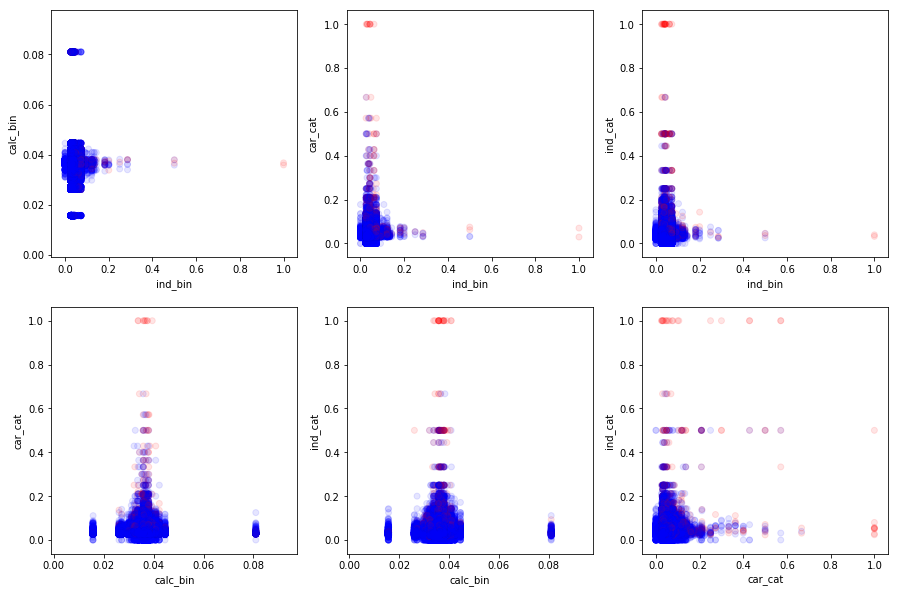

In [75]:
fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, 3, figsize=(15, 10))
ax1.scatter(combo.iloc[:, 1], combo.iloc[:, 2], c=target, cmap=cm.bwr, alpha=0.1)
ax2.scatter(combo.iloc[:, 1], combo.iloc[:, 3], c=target, cmap=cm.bwr, alpha=0.1)
ax3.scatter(combo.iloc[:, 1], combo.iloc[:, 4], c=target, cmap=cm.bwr, alpha=0.1)
ax4.scatter(combo.iloc[:, 2], combo.iloc[:, 3], c=target, cmap=cm.bwr, alpha=0.1)
ax5.scatter(combo.iloc[:, 2], combo.iloc[:, 4], c=target, cmap=cm.bwr, alpha=0.1)
ax6.scatter(combo.iloc[:, 3], combo.iloc[:, 4], c=target, cmap=cm.bwr, alpha=0.1)

ax1.set_xlabel('ind_bin')
ax2.set_xlabel('ind_bin')
ax3.set_xlabel('ind_bin')
ax4.set_xlabel('calc_bin')
ax5.set_xlabel('calc_bin')
ax6.set_xlabel('car_cat')

ax1.set_ylabel('calc_bin')
ax2.set_ylabel('car_cat')
ax3.set_ylabel('ind_cat')
ax4.set_ylabel('car_cat')
ax5.set_ylabel('ind_cat')
ax6.set_ylabel('ind_cat')

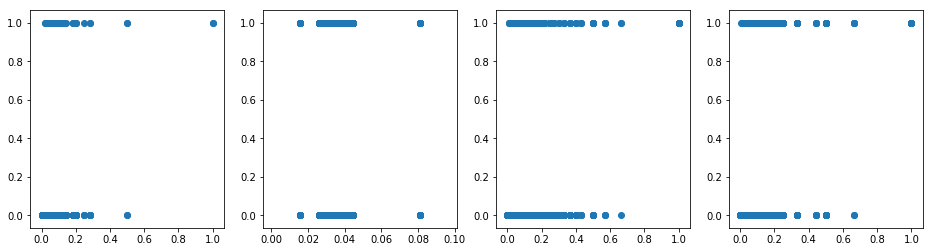

In [76]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(16, 4))
ax1.scatter(combo.iloc[:, 1], target)
ax2.scatter(combo.iloc[:, 2], target)
ax3.scatter(combo.iloc[:, 3], target)
ax4.scatter(combo.iloc[:, 4], target)

### With cont/ords

In [102]:
contord2 = contord_converted.copy()
del contord2['ps_calc_01']
del contord2['ps_calc_02']
del contord2['ps_calc_03']
del contord2['ps_calc_04']
del contord2['ps_calc_06']
del contord2['ps_calc_08']
del contord2['ps_calc_09']
del contord2['ps_calc_11']
del contord2['ps_calc_12']

In [110]:
reduced = pd.concat([combo.iloc[:, [1, 3, 4, 5]], contord2], axis=1)

In [111]:
reduced.head(5)

ind_bin   car_cat  car_cat2   ind_cat  ps_calc_05  ps_calc_07  ps_calc_10  \
0  0.072793  0.050438  0.032401  0.033319    0.036416    0.037201    0.035926   
1  0.044951  0.028005  0.026249  0.031885    0.036416    0.035555    0.036472   
2  0.036999  0.028005  0.023227  0.039012    0.036599    0.037201    0.036472   
3  0.026372  0.033865  0.023859  0.031885    0.036617    0.037201    0.036159   
4  0.026372  0.028005  0.030589  0.033319    0.036599    0.036004    0.035816   

   ps_calc_13  ps_calc_14  ps_car_11    ...      ps_car_13  ps_car_14  \
0    0.036635    0.035872   0.038387    ...       0.038135   0.034162   
1    0.036327    0.036731   0.036107    ...       0.029289   0.034343   
2    0.035492    0.036143   0.028171    ...       0.029937   0.034555   
3    0.036693    0.036731   0.028171    ...       0.027400   0.036728   
4    0.036327    0.034768   0.036107    ...       0.028020   0.034173   

   ps_car_15  ps_ind_01  ps_ind_03  ps_ind_14  ps_ind_15  ps_reg_01  \
0   0.041611   0.036703   0.038238   0.036301   0.031350   0.038495   
1   0.029716   0.033699   0.041305   0.036301   0.039499   0.038800   
2   0.038935   0.040509   0.036296   0.036301   0.030678   0.038008   
3   0.026866   0.033238   0.030755   0.036301   0.036074   0.041095   
4   0.026866   0.033238   0.053244   0.036301   0.032327   0.038495   

   ps_reg_02  ps_reg_03  
0   0.030080   0.034786  
1   0.035950   0.035853  
2   0.032287   0.028393  
3   0.030080   0.032475  
4   0.041890   0.037689  

[5 rows x 21 columns]

In [112]:
pca = PCA()
Xpca = pca.fit_transform(np.array(reduced))

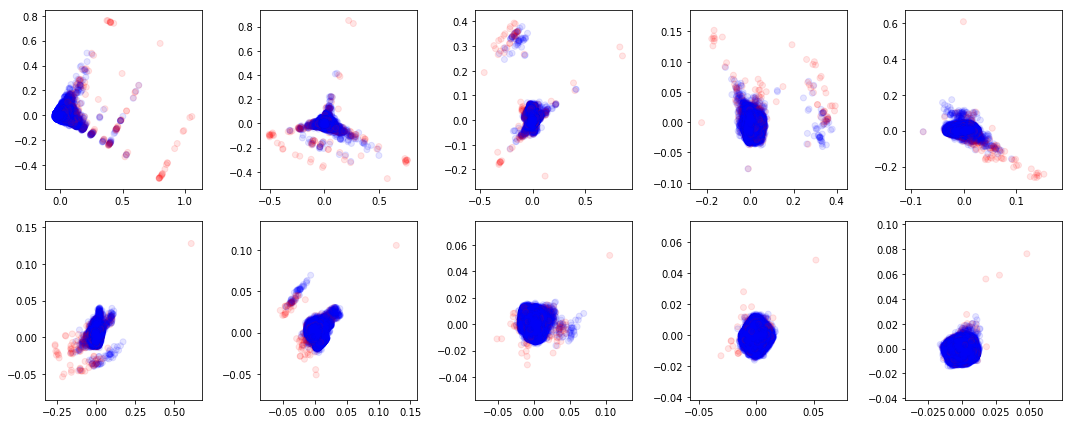

In [113]:
fig, ((ax1, ax2, ax3, ax4, ax5), (ax6, ax7, ax8, ax9, ax10)) = plt.subplots(2, 5, figsize=(15, 6))
ax1.scatter(Xpca[:, 0], Xpca[:, 1], c=target, cmap=cm.bwr, alpha=0.1)
ax2.scatter(Xpca[:, 1], Xpca[:, 2], c=target, cmap=cm.bwr, alpha=0.1)
ax3.scatter(Xpca[:, 2], Xpca[:, 3], c=target, cmap=cm.bwr, alpha=0.1)
ax4.scatter(Xpca[:, 3], Xpca[:, 4], c=target, cmap=cm.bwr, alpha=0.1)
ax5.scatter(Xpca[:, 4], Xpca[:, 5], c=target, cmap=cm.bwr, alpha=0.1)
ax6.scatter(Xpca[:, 5], Xpca[:, 6], c=target, cmap=cm.bwr, alpha=0.1)
ax7.scatter(Xpca[:, 6], Xpca[:, 7], c=target, cmap=cm.bwr, alpha=0.1)
ax8.scatter(Xpca[:, 7], Xpca[:, 8], c=target, cmap=cm.bwr, alpha=0.1)
ax9.scatter(Xpca[:, 8], Xpca[:, 9], c=target, cmap=cm.bwr, alpha=0.1)
ax10.scatter(Xpca[:, 9], Xpca[:, 10], c=target, cmap=cm.bwr, alpha=0.1)

plt.tight_layout()

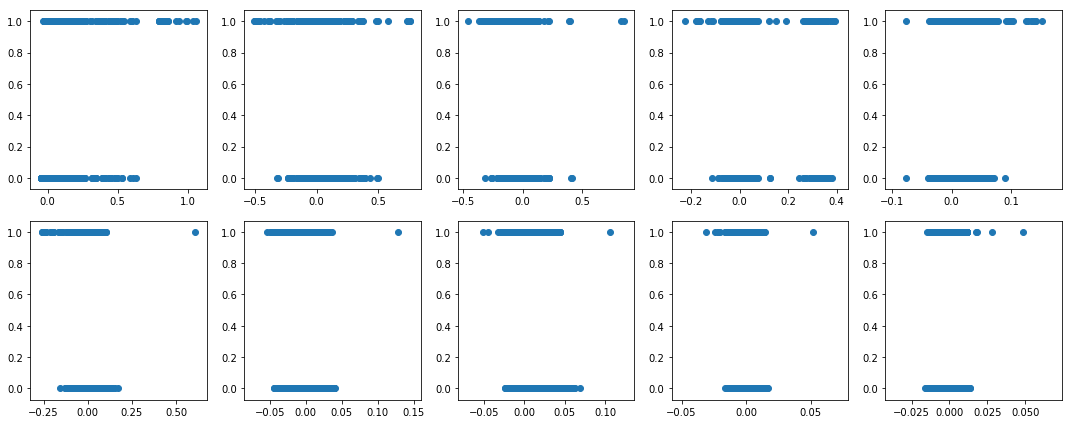

In [114]:
fig, ((ax1, ax2, ax3, ax4, ax5), (ax6, ax7, ax8, ax9, ax10)) = plt.subplots(2, 5, figsize=(15, 6))
ax1.scatter(Xpca[:, 0], target)
ax2.scatter(Xpca[:, 1], target)
ax3.scatter(Xpca[:, 2], target)
ax4.scatter(Xpca[:, 3], target)
ax5.scatter(Xpca[:, 4], target)
ax6.scatter(Xpca[:, 5], target)
ax7.scatter(Xpca[:, 6], target)
ax8.scatter(Xpca[:, 7], target)
ax9.scatter(Xpca[:, 8], target)
ax10.scatter(Xpca[:, 9], target)

plt.tight_layout()

In [120]:
Xpca.shape

(595212, 21)

# Try classification with combined features

In [115]:
X = np.array(reduced)
y = np.array(target)

Gini=0.309+/-0.016, Best=0.330
CPU times: user 4min 28s, sys: 285 ms, total: 4min 29s
Wall time: 38 s


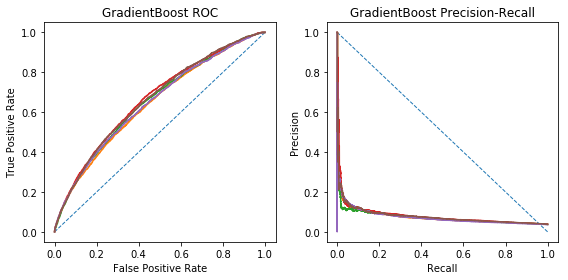

In [121]:
%%time
fig = plt.figure(figsize=(8, 4))
ax21 = fig.add_subplot(1, 2, 1)
ax22 = fig.add_subplot(1, 2, 2)

neutral_line = np.linspace(0, 1, 10)
ax21.plot(neutral_line, neutral_line, lw=1, ls='--')
ax22.plot(neutral_line, 1- neutral_line, lw=1, ls='--')

ginis_xgb = []

for i in range(5):

    rstate = None
    X_train, X_test, y_train, y_test = train_test_split(Xpca[:, :10], y, test_size=0.1, random_state=rstate)

    num_class1 = np.sum(y_train)
    num_class1_to_resample = 2 * num_class1
    num_class0_to_resample = int(1 * num_class1_to_resample)

    # First, randomly undersample the majority
    rus = RandomUnderSampler(ratio={0: num_class0_to_resample , 1: num_class1})
    X_tlrus, y_tlrus = rus.fit_sample(X_train, y_train)

    # Then use SMOTE to oversample the minority
    smote = SMOTE(ratio={0: num_class0_to_resample , 1: num_class1_to_resample}, n_jobs=8)
    X_res, y_res = smote.fit_sample(X_tlrus, y_tlrus)

    # GradientBoost
    clf = RandomForestClassifier(n_estimators=200, max_depth=10, n_jobs=8)
    clf.fit(X_res, y_res)

    y_pred2 = clf.predict(X_test)
    y_proba2 = clf.predict_proba(X_test)
    ginis_xgb.append(my_gini(y_test, y_proba2))
    report2 = classification_report(y_test, y_pred2, digits=4,
                                   labels=None, target_names=None)

    precision2, recall2, _ = precision_recall_curve(y_test, y_proba2[:, 1], pos_label=1)
    fpr2, tpr2, _ = roc_curve(y_test, y_proba2[:, 1], pos_label=1)
    ax21.plot(fpr2, tpr2)
    ax21.set_xlabel('False Positive Rate')
    ax21.set_ylabel('True Positive Rate')
    ax21.set_title('GradientBoost ROC')
    ax22.plot(recall2, precision2)
    ax22.set_xlabel('Recall')
    ax22.set_ylabel('Precision')
    ax22.set_title('GradientBoost Precision-Recall')

plt.tight_layout()

print('Gini=%.3f+/-%.3f, Best=%.3f' % (np.mean(ginis_xgb), np.std(ginis_xgb), np.max(ginis_xgb)))

In [122]:
clf.feature_importances_

array([ 0.38149197,  0.07338764,  0.07380663,  0.11172015,  0.0646338 ,
        0.06200095,  0.04753551,  0.06558638,  0.07205493,  0.04778204])